In [1]:
# ============================================================================
# AIRLINE CUSTOMER SATISFACTION - MILESTONE 1
# German University in Cairo - CSEN 903
# ============================================================================

# ============================================================================
# INSTALL REQUIRED PACKAGES
# ============================================================================

import sys
import subprocess

def install_package(package):
    """Install package if not already installed"""
    try:
        if package == 'vaderSentiment':
            from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
        elif package == 'shap':
            import shap
        elif package == 'lime':
            import lime
        print(f"✓ {package} already installed")
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "-q"])
        print(f"✓ {package} installed successfully")

print("Checking and installing required packages...")
print("="*70)
install_package('vaderSentiment')
install_package('shap')
install_package('lime')
print("="*70)
print("✓ All required packages ready!\n")

# ============================================================================
# PART 1: SETUP & DATA LOADING
# ============================================================================

print("="*70)
print("IMPORTING LIBRARIES")
print("="*70)

# Core data processing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("✓ Core libraries imported")

# For sentiment analysis
try:
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    print("✓ VADER Sentiment Analysis imported")
except ImportError as e:
    print(f" Error importing VADER: {e}")
    print("   Please restart kernel and run again")

# For ML models
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report, 
                             roc_curve, auc)
print("✓ Scikit-learn libraries imported")

# For Neural Networks
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping
    print(f"✓ TensorFlow {tf.__version__} imported")
except ImportError:
    print("TensorFlow not available - Neural Network will be skipped")

# For XAI (Explainable AI)
try:
    import shap
    print("✓ SHAP imported")
except ImportError as e:
    print(f" Error importing SHAP: {e}")

try:
    from lime import lime_tabular
    print("✓ LIME imported")
except ImportError as e:
    print(f"Error importing LIME: {e}")

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
print("✓ Visualization settings configured")

print("\n" + "="*70)
print("ALL LIBRARIES IMPORTED SUCCESSFULLY!")
print("="*70)

# Display versions
print("\nLibrary Versions:")
print(f"  Python: {sys.version.split()[0]}")
print(f"  Pandas: {pd.__version__}")
print(f"  NumPy: {np.__version__}")
import matplotlib
print(f"  Matplotlib: {matplotlib.__version__}")
print(f"  Seaborn: {sns.__version__}")
import sklearn
print(f"  Scikit-learn: {sklearn.__version__}")
try:
    print(f"  TensorFlow: {tf.__version__}")
except:
    print(f"  TensorFlow: Not available")
try:
    print(f"  SHAP: {shap.__version__}")
except:
    print(f"  SHAP: Version not available")

# Quick VADER test
print("\n" + "="*70)
print("TESTING VADER SENTIMENT ANALYZER")
print("="*70)
try:
    analyzer = SentimentIntensityAnalyzer()
    test_text = "This is an excellent flight with great service!"
    test_score = analyzer.polarity_scores(test_text)
    print(f"Test text: '{test_text}'")
    print(f"Sentiment scores: {test_score}")
    print("✓ VADER is working correctly!")
except Exception as e:
    print(f" VADER test failed: {e}")
    print("   Please restart kernel and try again")

# ============================================================================
# SIMPLIFIED DATA LOADING - ONLY CLEANEDCMS DATASET
# ============================================================================

print("\n" + "="*70)
print("LOADING DATASETS - CLEANED VERSION ONLY")
print("="*70)

# Initialize dataset variables
df_reviews = None
df_comments = None
df_booking = None
df_survey = None

try:
    # Dataset 1: Airline Scrapped Review (ONLY FROM CLEANEDCMS)
    print("\nLoading AirlineScrappedReview_Cleaned.csv from cleanedcms...")
    df_reviews = pd.read_csv('/kaggle/input/cleanedcms/AirlineScrappedReview_Cleaned.csv')
    print(f"✓ Loaded AirlineScrappedReview_Cleaned.csv: {df_reviews.shape}")

    # Dataset 2: Customer Comments
    print("\nLoading Customer_comment.csv...")
    df_comments = pd.read_csv('/kaggle/input/airline-passangers-booking-data/Customer_comment.csv')
    print(f"✓ Loaded Customer_comment.csv: {df_comments.shape}")

    # Dataset 3: Passenger Booking Data
    print("\nLoading Passanger_booking_data.csv...")
    df_booking = pd.read_csv('/kaggle/input/airline-passangers-booking-data/Passanger_booking_data.csv')
    print(f"✓ Loaded Passanger_booking_data.csv: {df_booking.shape}")

    # Dataset 4: Survey Data
    print("\nLoading Survey data_Inflight Satisfaction Score.csv...")
    df_survey = pd.read_csv('/kaggle/input/airline-passangers-booking-data/Survey data_Inflight Satisfaction Score.csv')
    print(f"✓ Loaded Survey data_Inflight Satisfaction Score.csv: {df_survey.shape}")

except FileNotFoundError as e:
    print(f"\nFile not found: {e}")
    print("\n Please check that:")
    print("   - All datasets are properly added to your Kaggle notebook")
    print("   - File paths are correct")
except Exception as e:
    print(f"\n Error loading files: {e}")

# Verify all datasets loaded
print("\n" + "="*70)
print("DATASET LOADING VERIFICATION")
print("="*70)

datasets_loaded = {
    'AirlineScrappedReview_Cleaned': df_reviews is not None,
    'Customer_comment': df_comments is not None,
    'Passanger_booking_data': df_booking is not None,
    'Survey_data_Inflight_Satisfaction': df_survey is not None
}

all_loaded = all(datasets_loaded.values())

for name, loaded in datasets_loaded.items():
    status = "✓" if loaded else "not loaded"
    print(f"{status} {name}: {'Loaded' if loaded else 'NOT LOADED'}")

if all_loaded:
    print("\n All datasets loaded successfully!")
else:
    print("\n WARNING: Some datasets failed to load!")
    print("   The notebook will continue with available datasets.")
print("="*70)

# ============================================================================
# INITIAL DATA EXPLORATION
# ============================================================================

print("\n" + "="*70)
print("INITIAL DATA EXPLORATION")
print("="*70)

# Function to explore dataset
def explore_dataset(df, name):
    """Explore and display information about a dataset"""
    if df is None:
        print(f"\n⚠ {name}: Dataset not loaded - skipping exploration")
        return
    
    print(f"\n{'='*70}")
    print(f"Dataset: {name}")
    print(f"{'='*70}")
    print(f"Shape: {df.shape} (rows: {df.shape[0]:,}, columns: {df.shape[1]})")
    
    print(f"\nColumn Names and Types:")
    print(df.dtypes)
    
    print(f"\nFirst 3 rows:")
    display(df.head(3))
    
    print(f"\nMissing Values:")
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print(missing[missing > 0])
    else:
        print("No missing values!")
    
    print(f"\nDuplicate Rows: {df.duplicated().sum()}")
    
    print(f"\nBasic Statistics (numerical columns):")
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    if len(numerical_cols) > 0:
        print(df[numerical_cols].describe())
    else:
        print("No numerical columns found")

# Explore each dataset (only if loaded)
if df_reviews is not None:
    explore_dataset(df_reviews, "AirlineScrappedReview_Cleaned")
else:
    print("\n AirlineScrappedReview_Cleaned not loaded - cannot explore")

if df_comments is not None:
    explore_dataset(df_comments, "Customer_comment")
else:
    print("\n Customer_comment not loaded - cannot explore")

if df_booking is not None:
    explore_dataset(df_booking, "Passanger_booking_data")
else:
    print("\n Passanger_booking_data not loaded - cannot explore")

if df_survey is not None:
    explore_dataset(df_survey, "Survey_data_Inflight_Satisfaction")
else:
    print("\n Survey_data_Inflight_Satisfaction not loaded - cannot explore")

# Final status
print("\n" + "="*70)
if all_loaded:
    print("✓ Initial data exploration complete!")
    print("\n DATASET SUMMARY:")
    print(f"   - Reviews: {df_reviews.shape}")
    print(f"   - Comments: {df_comments.shape}")
    print(f"   - Booking: {df_booking.shape}")
    print(f"   - Survey: {df_survey.shape}")
else:
    print(" Data exploration complete (with some datasets missing)")
    print("  The notebook will continue with available datasets.")
print("="*70)

Checking and installing required packages...
Installing vaderSentiment...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.7 MB/s eta 0:00:00
✓ vaderSentiment installed successfully
✓ shap already installed
✓ lime already installed
✓ All required packages ready!

IMPORTING LIBRARIES
✓ Core libraries imported
✓ VADER Sentiment Analysis imported
✓ Scikit-learn libraries imported


2025-10-23 22:03:41.257407: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761257021.476445      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761257021.537190      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✓ TensorFlow 2.18.0 imported
✓ SHAP imported
✓ LIME imported
✓ Visualization settings configured

ALL LIBRARIES IMPORTED SUCCESSFULLY!

Library Versions:
  Python: 3.11.13
  Pandas: 2.2.3
  NumPy: 1.26.4
  Matplotlib: 3.7.2
  Seaborn: 0.12.2
  Scikit-learn: 1.2.2
  TensorFlow: 2.18.0
  SHAP: 0.44.1

TESTING VADER SENTIMENT ANALYZER
Test text: 'This is an excellent flight with great service!'
Sentiment scores: {'neg': 0.0, 'neu': 0.426, 'pos': 0.574, 'compound': 0.8439}
✓ VADER is working correctly!

LOADING DATASETS - CLEANED VERSION ONLY

Loading AirlineScrappedReview_Cleaned.csv from cleanedcms...
✓ Loaded AirlineScrappedReview_Cleaned.csv: (3575, 18)

Loading Customer_comment.csv...
✓ Loaded Customer_comment.csv: (9424, 17)

Loading Passanger_booking_data.csv...
✓ Loaded Passanger_booking_data.csv: (50002, 14)

Loading Survey data_Inflight Satisfaction Score.csv...
✓ Loaded Survey data_Inflight Satisfaction Score.csv: (47074, 31)

DATASET LOADING VERIFICATION
✓ AirlineScrappedReview

,Passanger_Name,Flying_Date,Route,Rating,Verified,Review_title,Review_content,Traveller_Type,Class,Start_Location,End_Location,Layover_Route,Start_Latitude,Start_Longitude,Start_Address,End_Latitude,End_Longitude,End_Address
0,Paige Boet,June 2023,New Orleans to London,1,Trip Verified,The airline lost my luggage,The airline lost my luggage and was absolutely...,Solo Leisure,Economy Class,New Orleans,London,NaN,29.975998,-90.078213,"New Orleans, Orleans Parish, Louisiana, United...",51.507446,-0.127765,"London, Greater London, England, United Kingdom"
1,S Layne,March 2023,London to Amman,1,Trip Verified,fully refunded by our travel insurance,"We booked on the BA website, round trip flight...",Couple Leisure,Business Class,London,Amman,NaN,51.507446,-0.127765,"London, Greater London, England, United Kingdom",31.951569,35.923963,"عمان, ناحية عمان, لواء قصبة عمان, عمان, 11110,..."
2,E Lanewoski,NaN,Heathrow to Bodrum,2,Trip Verified,no boarding drinks provided,"First time flying with BA business class, neve...",Solo Leisure,Business Class,London Heathrow,Bodrum,NaN,51.467739,-0.458780,"London Heathrow Airport, The Beacon Roundabout...",37.034399,27.430651,"Bodrum, Muğla, Ege Bölgesi, Türkiye"



Missing Values:
Passanger_Name        1
Flying_Date        2620
Route               766
Start_Location      766
End_Location        766
Layover_Route      3091
Start_Latitude       60
Start_Longitude      60
Start_Address        60
End_Latitude         99
End_Longitude        99
End_Address          99
dtype: int64

Duplicate Rows: 74

Basic Statistics (numerical columns):
            Rating  Start_Latitude  Start_Longitude  End_Latitude  \
count  3575.000000     3515.000000      3515.000000   3476.000000   
mean      4.790490       42.639473        -2.164986     40.550399   
std       3.170323       17.022014        44.576587     18.723619   
min       1.000000      -37.666951      -123.182909    -37.814245   
25%       2.000000       41.893320        -0.458780     39.739236   
50%       4.000000       46.314475        -0.127765     46.314475   
75%       8.000000       51.467739        11.048029     51.467739   
max      10.000000       65.011873       151.208285     64.145981   

 

,Unnamed: 0,flight_number,origin_station_code,destination_station_code,scheduled_departure_date,arrival_delay_group,departure_delay_group,entity,verbatim_text,seat_factor_band,ques_verbatim_text,loyalty_program_level,fleet_type_description,fleet_usage,response_group,sentiments,transformed_text
0,0,950,LHX,SFX,2022-09-01,Early & Ontime,Delayed,Atlantic,There was no salad dressing. The staff informe...,0 to 70,Is there anything else you'd like to share abo...,non-elite,B777-200,Mainline,member,Neutral,salad dress staff inform flight receiv salad d...
1,1,950,LHX,SFX,2022-09-01,Early & Ontime,Delayed,Atlantic,Not a choice.,0 to 70,Is there anything else you'd like to share abo...,NaN,B777-200,Mainline,non-member,Neutral,choic
2,2,1876,FLX,EWX,2022-09-01,Early & Ontime,Early & Ontime,Domestic,More variety and bigger snacks.,90+,Is there anything else you'd like to share abo...,non-elite,A320-200,Mainline,member,Neutral,varieti bigger snack



Missing Values:
loyalty_program_level    2504
transformed_text         1019
dtype: int64

Duplicate Rows: 0

Basic Statistics (numerical columns):
        Unnamed: 0  flight_number
count  9424.000000    9424.000000
mean   4711.500000    1741.573430
std    2720.618802    1550.550037
min       0.000000       2.000000
25%    2355.750000     614.000000
50%    4711.500000    1286.000000
75%    7067.250000    2261.000000
max    9423.000000    6375.000000

Dataset: Passanger_booking_data
Shape: (50002, 14) (rows: 50,002, columns: 14)

Column Names and Types:
num_passengers             int64
sales_channel             object
trip_type                 object
purchase_lead              int64
length_of_stay             int64
flight_hour                int64
flight_day                object
route                     object
booking_origin            object
wants_extra_baggage        int64
wants_preferred_seat       int64
wants_in_flight_meals      int64
flight_duration          float64
booking_comp

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,1,Internet,RoundTrip,21,12,6,Tue,AKLHGH,Australia,0,0,0,7.21,1
1,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
2,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0



Missing Values:
No missing values!

Duplicate Rows: 719

Basic Statistics (numerical columns):
       num_passengers  purchase_lead  length_of_stay   flight_hour  \
count    50002.000000   50002.000000    50002.000000  50002.000000   
mean         1.591256      84.940582       23.044778      9.066277   
std          1.020167      90.450548       33.887171      5.412569   
min          1.000000       0.000000        0.000000      0.000000   
25%          1.000000      21.000000        5.000000      5.000000   
50%          1.000000      51.000000       17.000000      9.000000   
75%          2.000000     115.000000       28.000000     13.000000   
max          9.000000     867.000000      778.000000     23.000000   

       wants_extra_baggage  wants_preferred_seat  wants_in_flight_meals  \
count         50002.000000          50002.000000           50002.000000   
mean              0.668773              0.296968               0.427143   
std               0.470659              0.456927

,flight_number,origin_station_code,destination_station_code,record_locator,scheduled_departure_date,question_text,score,satisfaction_type,driver_sub_group1,driver_sub_group2,...,equipment_type_code,ua_uax,actual_flown_miles,haul_type,departure_gate,arrival_gate,international_domestic_indicator,response_group,media_provider,hub_spoke
0,3802,MKX,ORX,CYXXJJ,9/1/2022,How satisfied were you with the food & beverag...,2,Dissatisfied,food & beverage,food and beverage satisfaction,...,CRZ,UAX,67,Short,C12,F10,Domestic,non-member,NaN,spoke departure
1,4645,COX,DEX,DRXXMH,9/1/2022,How satisfied were you with the food & beverag...,5,Satisfied,food & beverage,food and beverage satisfaction,...,E75,UAX,72,Short,5,B60,Domestic,member,GOGO,spoke departure
2,5236,COX,DEX,DEXXS1,9/1/2022,How satisfied were you with the food & beverag...,5,Satisfied,food & beverage,food and beverage satisfaction,...,E75,UAX,72,Short,7,A71,Domestic,member,GOGO,spoke departure



Missing Values:
satisfaction_type        12111
cabin_name               19980
entity                       3
loyalty_program_level    11616
departure_gate              97
arrival_gate               527
media_provider            1539
dtype: int64

Duplicate Rows: 0

Basic Statistics (numerical columns):
       flight_number  arrival_delay_minutes  number_of_legs  \
count   47074.000000           47074.000000    47074.000000   
mean     1529.855207              -1.702490        1.344118   
std      1456.712299              37.868177        0.502424   
min         2.000000            -104.000000        1.000000   
25%       477.000000             -19.000000        1.000000   
50%      1050.000000              -9.000000        1.000000   
75%      2060.000000               4.000000        2.000000   
max      6376.000000             907.000000        3.000000   

       actual_flown_miles  
count        47074.000000  
mean          2477.737732  
std           1865.646538  
min            

# Milestone 1: Airline Customer Satisfaction - Setup & Data Loading

**What this cell does:**  
1. Checks and installs required Python packages (`vaderSentiment`, `shap`, `lime`).  
2. Imports all necessary libraries for data processing, visualization, machine learning, and sentiment analysis.  
3. Loads the cleaned datasets into pandas dataframes.  
4. Verifies that all datasets are loaded correctly.  
5. Performs an initial exploration of each dataset (shape, columns, missing values, duplicates, basic statistics).  
6. Tests the VADER sentiment analyzer to make sure it works.

**Why this is important:**  
- Without installing and importing libraries, the rest of the notebook won't run.  
- Loading the datasets correctly is the first step before any analysis or modeling.  
- Exploring the datasets helps us understand the data, find issues, and plan next steps.  

**Questions a student might ask:**  
- *Q: Why do we check for missing values?*  
  A: Missing values can cause errors or affect model performance.  
- *Q: What is a dataframe?*  
  A: It's a table-like structure in Python with rows and columns, which makes data easier to work with.  
- *Q: Why test VADER?*  
  A: To make sure sentiment analysis is working before using it on all reviews.  


In [2]:

import pandas as pd
import numpy as np
from typing import Any, Optional, Tuple

def safe_copy(df: Optional[pd.DataFrame], name: str) -> Optional[pd.DataFrame]:
    """Return a copy if df is a DataFrame, otherwise print warning and return None."""
    if df is None:
        print(f"  Warning: {name} is not loaded (None). Skipping.")
        return None
    if not isinstance(df, pd.DataFrame):
        print(f" Warning: {name} is not a pandas DataFrame (type: {type(df)}). Skipping.")
        return None
    print(f"✓ {name} loaded: shape {df.shape}")
    return df.copy()

def safe_mode(series: pd.Series, fallback: Any = "Unknown") -> Any:
    """Return the first mode or fallback if no mode exists."""
    modes = series.mode(dropna=True)
    if modes.empty:
        return fallback
    return modes.iloc[0]

def fill_categorical(series: pd.Series, fallback: Any = "Unknown") -> pd.Series:
    """Fill categorical (object) series with mode or fallback."""
    try:
        fill_val = safe_mode(series, fallback)
        return series.fillna(fill_val)
    except Exception:
        return series.fillna(fallback)

def fill_numeric_with_median(series: pd.Series, fallback: float = 0.0) -> pd.Series:
    """Fill numeric series with median (fallback to 0 if median can't be computed)."""
    try:
        med = series.median(skipna=True)
        if pd.isna(med):
            med = fallback
        return series.fillna(med)
    except Exception:
        return series.fillna(fallback)

def normalize_column_names(df: pd.DataFrame) -> pd.DataFrame:
    """Standardize column names: strip, replace spaces with underscore."""
    df = df.rename(columns=lambda c: str(c).strip().replace(' ', '_'))
    return df

def trim_whitespace_in_object_cols(df: pd.DataFrame) -> pd.DataFrame:
    """Strip leading/trailing whitespace for string columns."""
    obj_cols = df.select_dtypes(include=['object', 'string']).columns
    for c in obj_cols:
        df[c] = df[c].astype(str).str.strip().replace({'nan': np.nan})
    return df

df_reviews_clean  = safe_copy(globals().get("df_reviews"), "AirlineScrappedReview_Cleaned")  # CHANGED TO CLEANED VERSION
df_comments_clean = safe_copy(globals().get("df_comments"), "Customer_comment")
df_booking_clean  = safe_copy(globals().get("df_booking"), "Passanger_booking_data")
df_survey_clean   = safe_copy(globals().get("df_survey"), "Survey_data_Inflight_Satisfaction")

print("\nSetup complete. Proceeding to cleaning for loaded datasets.\n")

def clean_dataframe(df: pd.DataFrame,
                    name: str,
                    fill_review_text: bool = False,
                    review_text_col: str = "Review_content",
                    review_title_col: str = "Review_title",
                    drop_high_missing_pct: float = 50.0,
                    auto_drop_high_missing: bool = False) -> Tuple[pd.DataFrame, dict]:
    """
    General cleaning routine with documented decisions.
    Returns cleaned df and a log dict of actions taken.
    """
    log = {"name": name, "original_shape": df.shape, "actions": []}
    
    # Normalize column names + trim whitespace
    df = normalize_column_names(df)
    df = trim_whitespace_in_object_cols(df)
    log["actions"].append("Normalized column names and trimmed whitespace")
    
    # Document missing value counts
    missing_series = df.isnull().sum()
    missing_info = missing_series[missing_series > 0].sort_values(ascending=False)
    log["missing_before"] = missing_info.to_dict()
    if not missing_info.empty:
        log["actions"].append(f"Found {len(missing_info)} columns with missing values")
    
    # Decision: drop columns with > drop_high_missing_pct missing values (flag or drop)
    cols_to_drop = []
    total_rows = len(df)
    for col, miss in missing_info.items():
        pct = (miss / total_rows) * 100
        if pct > drop_high_missing_pct:
            cols_to_drop.append(col)
    
    if cols_to_drop:
        if auto_drop_high_missing:
            df.drop(columns=cols_to_drop, inplace=True)
            log["actions"].append(f"Auto-dropped columns with >{drop_high_missing_pct}% missing: {cols_to_drop}")
        else:
            log["actions"].append(f"Flagged columns with >{drop_high_missing_pct}% missing (not auto-dropped): {cols_to_drop}")
    
    # Special case: fill review text/title placeholders if asked and columns exist
    if fill_review_text:
        if review_text_col in df.columns:
            cnt = df[review_text_col].isnull().sum()
            if cnt > 0:
                df[review_text_col] = df[review_text_col].fillna("No review provided")
                log["actions"].append(f"Filled {cnt} missing '{review_text_col}' with 'No review provided'")
        if review_title_col in df.columns:
            cnt = df[review_title_col].isnull().sum()
            if cnt > 0:
                df[review_title_col] = df[review_title_col].fillna("No title")
                log["actions"].append(f"Filled {cnt} missing '{review_title_col}' with 'No title'")
    
    # Fill remaining missing values column-wise
    for col in df.columns:
        miss = df[col].isnull().sum()
        if miss == 0:
            continue
        if df[col].dtype == 'object' or pd.api.types.is_string_dtype(df[col]):
            fill_val = safe_mode(df[col], fallback="Unknown")
            df[col] = df[col].fillna(fill_val)
            log["actions"].append(f"Filled {miss} missing in object column '{col}' with mode/fallback '{fill_val}'")
        elif pd.api.types.is_numeric_dtype(df[col]):
            med = df[col].median(skipna=True)
            if pd.isna(med):
                med = 0.0
            df[col] = df[col].fillna(med)
            log["actions"].append(f"Filled {miss} missing in numeric column '{col}' with median {med}")
        else:
            # For other dtypes (datetime, category, etc.)
            if pd.api.types.is_datetime64_any_dtype(df[col]):
                # Fill datetimes with forward fill then backward fill as fallback
                df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
                df[col] = df[col].fillna(pd.NaT)
                log["actions"].append(f"Attempted to fill datetime column '{col}' with ffill/bfill")
            else:
                df[col] = df[col].fillna("Unknown")
                log["actions"].append(f"Filled {miss} missing in other column '{col}' with 'Unknown'")
    
    # Remove exact duplicate rows
    dup_before = df.duplicated().sum()
    if dup_before > 0:
        df.drop_duplicates(inplace=True)
    dup_after = df.duplicated().sum()
    log["actions"].append(f"Removed {dup_before - dup_after} duplicate rows (before: {dup_before})")
    
    # Final shape and missing check
    log["cleaned_shape"] = df.shape
    log["missing_after"] = int(df.isnull().sum().sum())
    log["rows_removed"] = log["original_shape"][0] - log["cleaned_shape"][0]
    
    return df, log

results_logs = []

if df_reviews_clean is not None:
    df_reviews_clean, log_reviews = clean_dataframe(
        df_reviews_clean,
        name="AirlineScrappedReview_Cleaned",  # CHANGED NAME TO REFLECT CLEANED VERSION
        fill_review_text=True,
        review_text_col="Review_content",
        review_title_col="Review_title",
        drop_high_missing_pct=50.0,
        auto_drop_high_missing=False
    )
    results_logs.append(log_reviews)

if df_comments_clean is not None:
    df_comments_clean, log_comments = clean_dataframe(
        df_comments_clean,
        name="Customer_comment",
        fill_review_text=False,
        drop_high_missing_pct=50.0,
        auto_drop_high_missing=False
    )
    results_logs.append(log_comments)

if df_booking_clean is not None:
    df_booking_clean, log_booking = clean_dataframe(
        df_booking_clean,
        name="Passanger_booking_data",
        fill_review_text=False,
        drop_high_missing_pct=50.0,
        auto_drop_high_missing=False
    )
    results_logs.append(log_booking)

if df_survey_clean is not None:
    df_survey_clean, log_survey = clean_dataframe(
        df_survey_clean,
        name="Survey_data_Inflight_Satisfaction",
        fill_review_text=False,
        drop_high_missing_pct=50.0,
        auto_drop_high_missing=False
    )
    results_logs.append(log_survey)

print("\n" + "="*70)
print("DATA CLEANING SUMMARY")
print("="*70)

for log in results_logs:
    print(f"\n {log['name']}:")
    print(f"   Original shape: {log['original_shape']}")
    print(f"   Cleaned shape:  {log['cleaned_shape']}")
    print(f"   Rows removed:   {log['rows_removed']}")
    print(f"   Missing after:  {log['missing_after']}")
    print(f"   Actions taken ({len(log['actions'])}):")
    for action in log['actions']:
        print(f"     • {action}")

print("\n" + "="*70)
print("CLEANED DATASETS READY FOR ANALYSIS")
print("="*70)

# Display cleaned dataset info
print("\nCleaned Dataset Shapes:")
if df_reviews_clean is not None:
    print(f"✓ AirlineScrappedReview_Cleaned: {df_reviews_clean.shape}")
if df_comments_clean is not None:
    print(f"✓ Customer_comment: {df_comments_clean.shape}")
if df_booking_clean is not None:
    print(f"✓ Passanger_booking_data: {df_booking_clean.shape}")
if df_survey_clean is not None:
    print(f"✓ Survey_data_Inflight_Satisfaction: {df_survey_clean.shape}")

print("\n" + "="*70)
print("FINAL MISSING VALUES CHECK")
print("="*70)

datasets_to_check = [
    (df_reviews_clean, "AirlineScrappedReview_Cleaned"),
    (df_comments_clean, "Customer_comment"),
    (df_booking_clean, "Passanger_booking_data"),
    (df_survey_clean, "Survey_data_Inflight_Satisfaction")
]

all_clean = True
for df, name in datasets_to_check:
    if df is not None:
        missing_total = df.isnull().sum().sum()
        status = "✓ CLEAN" if missing_total == 0 else f"❌ {missing_total} missing"
        print(f"{name}: {status}")
        if missing_total > 0:
            all_clean = False
    else:
        print(f"{name}: ⚠ NOT LOADED")

if all_clean:
    print("\n ALL DATASETS ARE COMPLETELY CLEAN - READY FOR ANALYSIS!")
else:
    print("\n⚠ Some datasets still have missing values - consider additional cleaning steps.")

print("="*70)


✓ AirlineScrappedReview_Cleaned loaded: shape (3575, 18)
✓ Customer_comment loaded: shape (9424, 17)
✓ Passanger_booking_data loaded: shape (50002, 14)
✓ Survey_data_Inflight_Satisfaction loaded: shape (47074, 31)

Setup complete. Proceeding to cleaning for loaded datasets.


DATA CLEANING SUMMARY

 AirlineScrappedReview_Cleaned:
   Original shape: (3575, 18)
   Cleaned shape:  (3501, 18)
   Rows removed:   74
   Missing after:  0
   Actions taken (16):
     • Normalized column names and trimmed whitespace
     • Found 12 columns with missing values
     • Flagged columns with >50.0% missing (not auto-dropped): ['Layover_Route', 'Flying_Date']
     • Filled 1 missing in object column 'Passanger_Name' with mode/fallback 'David Ellis'
     • Filled 2620 missing in object column 'Flying_Date' with mode/fallback 'August 2015'
     • Filled 766 missing in object column 'Route' with mode/fallback 'London to Johannesburg'
     • Filled 766 missing in object column 'Start_Location' with mode/f

# Step 2: Cleaning the Datasets

**What this cell does:**  
1. Makes safe copies of all loaded datasets to avoid changing the original data.  
2. Defines helper functions to:  
   - Fill missing categorical values with mode or "Unknown".  
   - Fill numeric columns with median.  
   - Normalize column names and remove extra spaces.  
3. Cleans each dataset by:  
   - Trimming whitespace in string columns.  
   - Filling missing values intelligently.  
   - Dropping or flagging columns with too many missing values.  
   - Removing exact duplicate rows.  
4. Logs all cleaning steps for review.  
5. Displays a summary of changes, including shapes, missing values, and actions taken.

**Why this is important:**  
- Clean data is crucial for accurate analysis and machine learning.  
- Missing values or messy text can cause errors or reduce model performance.  
- Logging cleaning steps makes the process transparent and reproducible.

**Questions a student might ask:**  
- *Q: Why fill missing values with mode or median?*  
  A: Mode works for categories; median works for numbers without being affected by outliers.  
- *Q: Why normalize column names?*  
  A: Makes it easier to access columns consistently in code.  
- *Q: What happens to duplicate rows?*  
  A: Exact duplicates are removed to avoid counting the same data multiple times.  
- *Q: Why do we log cleaning actions?*  
  A: So we know exactly what was changed and can explain it in reports.


,dataset,original_rows,original_cols,cleaned_rows,cleaned_cols,rows_removed,missing_after,num_actions,actions_preview
0,AirlineScrappedReview_Cleaned,3575,18,3501,18,74,0,16,Normalized column names and trimmed whitespace...
1,Customer_comment,9424,17,9424,17,0,0,5,Normalized column names and trimmed whitespace...
2,Passanger_booking_data,50002,14,49283,14,719,0,2,Normalized column names and trimmed whitespace...
3,Survey_data_Inflight_Satisfaction,47074,31,47074,31,0,0,10,Normalized column names and trimmed whitespace...


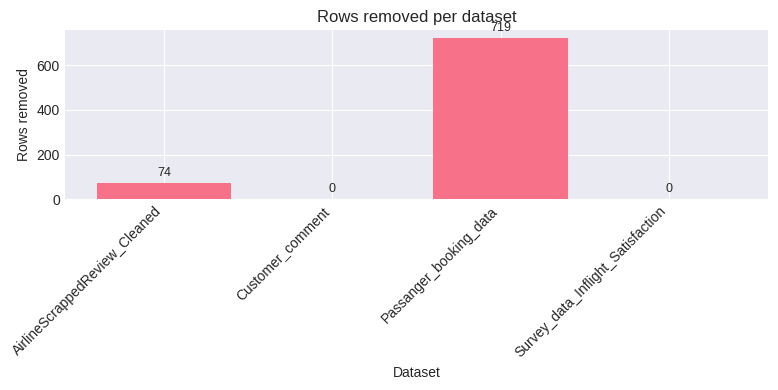

Saved plot to: /mnt/data/rows_removed.png


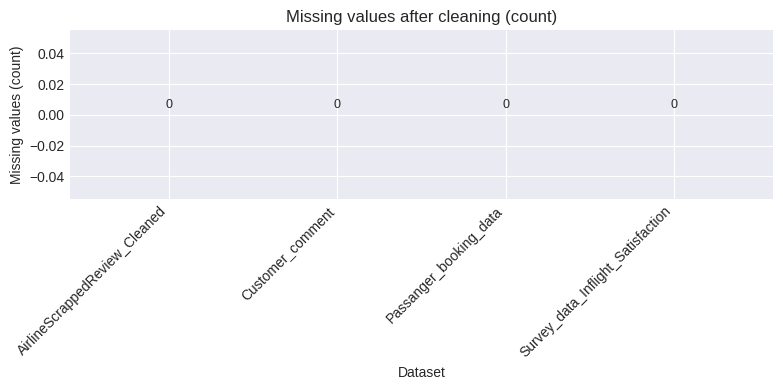

Saved plot to: /mnt/data/missing_after.png


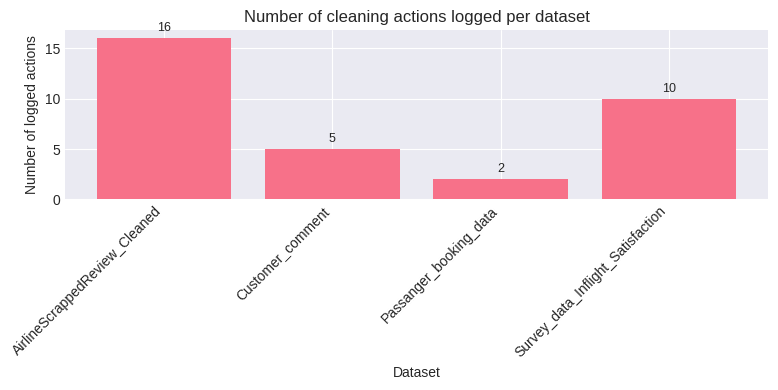

In [3]:
#aboveee cell visualizationnnn report and graphs 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


if 'results_logs' not in globals() or not isinstance(results_logs, list) or len(results_logs) == 0:
    raise RuntimeError("`results_logs` not found or empty. Run the cleaning cell first in the same notebook kernel.")


summary_rows = []
for log in results_logs:
    name = log.get("name", "unknown")
    orig_shape = log.get("original_shape", (np.nan, np.nan))
    cleaned_shape = log.get("cleaned_shape", (np.nan, np.nan))
    orig_rows, orig_cols = orig_shape if isinstance(orig_shape, (list, tuple)) else (np.nan, np.nan)
    clean_rows, clean_cols = cleaned_shape if isinstance(cleaned_shape, (list, tuple)) else (np.nan, np.nan)
    rows_removed = log.get("rows_removed", (orig_rows - clean_rows) if (not pd.isna(orig_rows) and not pd.isna(clean_rows)) else np.nan)
    missing_after = log.get("missing_after", np.nan)
    actions = log.get("actions", [])
    summary_rows.append({
        "dataset": name,
        "original_rows": int(orig_rows) if not pd.isna(orig_rows) else np.nan,
        "original_cols": int(orig_cols) if not pd.isna(orig_cols) else np.nan,
        "cleaned_rows": int(clean_rows) if not pd.isna(clean_rows) else np.nan,
        "cleaned_cols": int(clean_cols) if not pd.isna(clean_cols) else np.nan,
        "rows_removed": int(rows_removed) if not pd.isna(rows_removed) else 0,
        "missing_after": int(missing_after) if not pd.isna(missing_after) else 0,
        "num_actions": len(actions),
        "actions_preview": " | ".join(actions[:6]) + ("" if len(actions) <= 6 else " | ...")
    })

summary_df = pd.DataFrame(summary_rows).sort_values("dataset").reset_index(drop=True)


try:
    from caas_jupyter_tools import display_dataframe_to_user
    display_dataframe_to_user("Cleaning Summary", summary_df)
except Exception:
    display(summary_df)  # fallback to plain notebook display

out_dir = "/mnt/data"
os.makedirs(out_dir, exist_ok=True)
csv_path = os.path.join(out_dir, "cleaning_summary.csv")
summary_df.to_csv(csv_path, index=False)

def annotate_bars(ax, rects, fmt="{:.0f}", pad=3):
    for rect in rects:
        h = rect.get_height()
        ax.annotate(fmt.format(h),
                    xy=(rect.get_x() + rect.get_width() / 2, h),
                    xytext=(0, pad),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)


x = summary_df["dataset"].astype(str).values
rows_removed_vals = summary_df["rows_removed"].values
plt.figure(figsize=(8,4))
ax = plt.gca()
bars = ax.bar(x, rows_removed_vals)
ax.set_title("Rows removed per dataset")
ax.set_xlabel("Dataset")
ax.set_ylabel("Rows removed")
plt.xticks(rotation=45, ha="right")
annotate_bars(ax, bars)
plt.tight_layout()
plot1 = os.path.join(out_dir, "rows_removed.png")
plt.savefig(plot1, bbox_inches="tight")
plt.show()
print(f"Saved plot to: {plot1}")

# --- Plot 2: Missing values after cleaning per dataset ---
missing_after_vals = summary_df["missing_after"].values
plt.figure(figsize=(8,4))
ax = plt.gca()
bars = ax.bar(x, missing_after_vals)
ax.set_title("Missing values after cleaning (count)")
ax.set_xlabel("Dataset")
ax.set_ylabel("Missing values (count)")
plt.xticks(rotation=45, ha="right")
annotate_bars(ax, bars)
plt.tight_layout()
plot2 = os.path.join(out_dir, "missing_after.png")
plt.savefig(plot2, bbox_inches="tight")
plt.show()
print(f"Saved plot to: {plot2}")

num_actions_vals = summary_df["num_actions"].values
plt.figure(figsize=(8,4))
ax = plt.gca()
bars = ax.bar(x, num_actions_vals)
ax.set_title("Number of cleaning actions logged per dataset")
ax.set_xlabel("Dataset")
ax.set_ylabel("Number of logged actions")
plt.xticks(rotation=45, ha="right")
annotate_bars(ax, bars)
plt.tight_layout()
plot3 = os.path.join(out_dir, "num_actions.png")
plt.savefig(plot3, bbox_inches="tight")
plt.show()





# Step 3: Cleaning Summary & Visualization

**What this cell does:**  
1. Creates a summary table of all datasets after cleaning, including:  
   - Original shape (rows and columns)  
   - Cleaned shape  
   - Number of rows removed  
   - Remaining missing values  
   - Number of cleaning actions performed  
2. Displays the summary table in the notebook and saves it as `cleaning_summary.csv`.  
3. Generates bar plots for:  
   - Rows removed per dataset  
   - Missing values remaining after cleaning  
   - Number of cleaning actions logged per dataset  
4. Saves all plots to `/mnt/data` folder.

**Why this is important:**  
- Helps visually confirm how much data was cleaned.  
- Shows which datasets needed the most cleaning.  
- Makes it easier to communicate results in reports or presentations.

**Questions a student might ask:**  
- *Q: Why make a summary table?*  
  A: So we can see all cleaning results in one place.  
- *Q: Why plot rows removed and missing values?*  
  A: Visuals make it easier to understand the impact of cleaning.  
- *Q: Why save the plots and CSV?*  
  A: We can use them in reports or later stages without rerunning the notebook.  
- *Q: What does `num_actions` mean?*  
  A: It counts how many cleaning steps were applied to each dataset.



SENTIMENT ANALYSIS

Applying VADER sentiment analysis to reviews
✓ Sentiment analysis complete!

Sentiment Distribution:
Sentiment_Analysis
Positive    2028
Negative    1433
Neutral       40
Name: count, dtype: int64

Sentiment Percentages:
Sentiment_Analysis
Positive    57.926307
Negative    40.931163
Neutral      1.142531
Name: proportion, dtype: float64


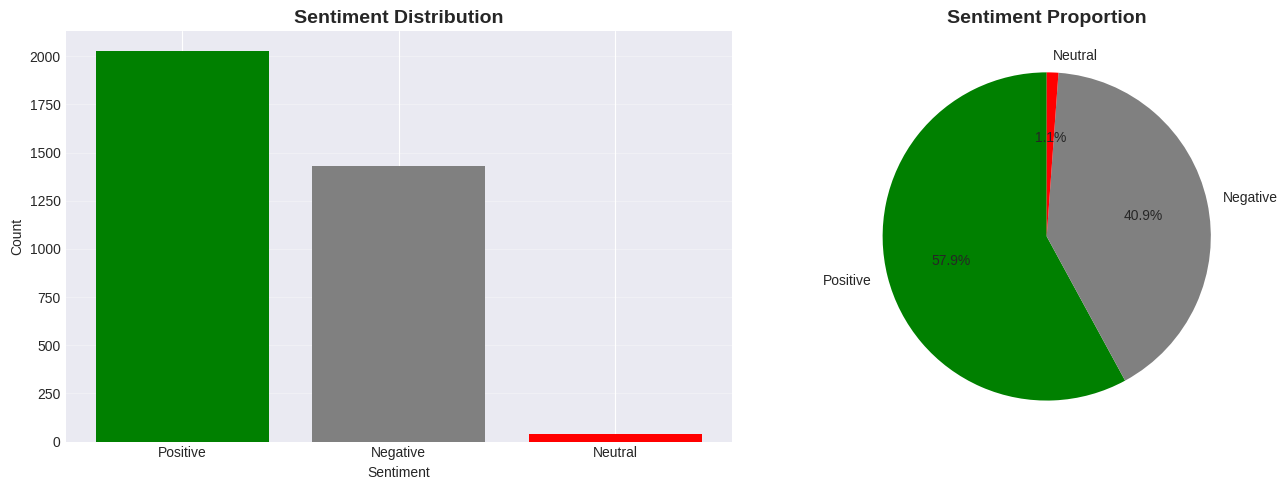

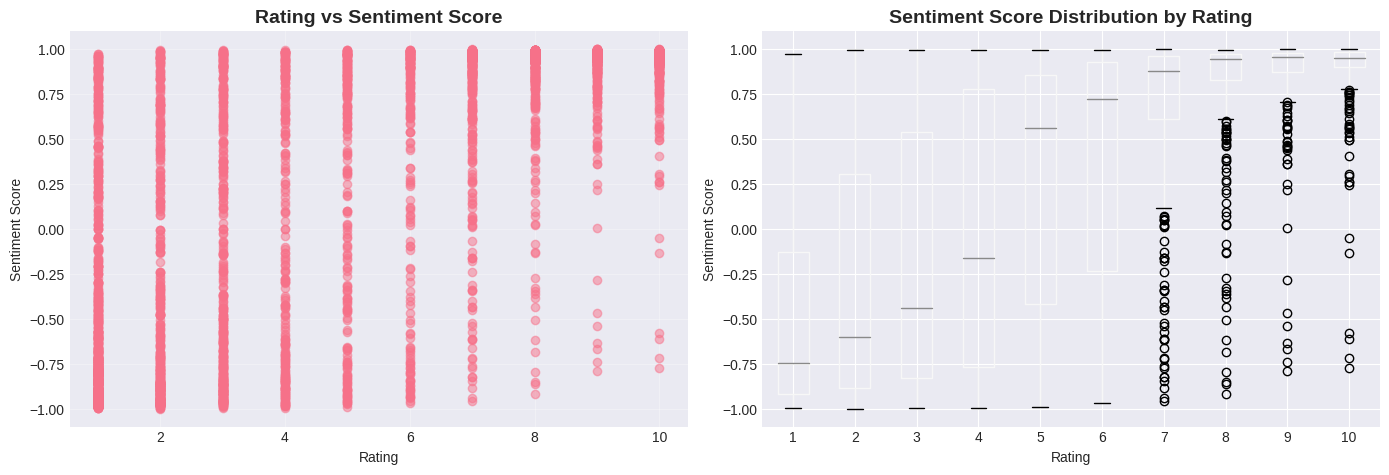

In [4]:

#  SENTIMENT ANALYSIS

print("\n" + "="*70)
print("SENTIMENT ANALYSIS")
print("="*70)

analyzer = SentimentIntensityAnalyzer()

def get_sentiment_score(text):
  
    if pd.isna(text) or text == "No review provided":
        return 0.0  # Neutral for missing reviews
    
    scores = analyzer.polarity_scores(str(text))
    return scores['compound']  # Compound score is the normalized score

def classify_sentiment(score):
    """
    Classify sentiment based on compound score:
    - Positive: score >= 0.05
    - Negative: score <= -0.05
    - Neutral: -0.05 < score < 0.05
    """
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

if df_reviews_clean is not None:
    print("\nApplying VADER sentiment analysis to reviews")
    df_reviews_clean['Sentiment_Score'] = df_reviews_clean['Review_content'].apply(get_sentiment_score)
    df_reviews_clean['Sentiment_Analysis'] = df_reviews_clean['Sentiment_Score'].apply(classify_sentiment)

    print("✓ Sentiment analysis complete!")

    print("\nSentiment Distribution:")
    print(df_reviews_clean['Sentiment_Analysis'].value_counts())
    print("\nSentiment Percentages:")
    print(df_reviews_clean['Sentiment_Analysis'].value_counts(normalize=True) * 100)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    sentiment_counts = df_reviews_clean['Sentiment_Analysis'].value_counts()
    axes[0].bar(sentiment_counts.index, sentiment_counts.values, color=['green', 'gray', 'red'])
    axes[0].set_title('Sentiment Distribution', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Sentiment')
    axes[0].set_ylabel('Count')
    axes[0].grid(axis='y', alpha=0.3)
    
    axes[1].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%',
                colors=['green', 'gray', 'red'], startangle=90)
    axes[1].set_title('Sentiment Proportion', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

    if 'Rating' in df_reviews_clean.columns:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Scatter plot
        axes[0].scatter(df_reviews_clean['Rating'], df_reviews_clean['Sentiment_Score'], alpha=0.5)
        axes[0].set_title('Rating vs Sentiment Score', fontsize=14, fontweight='bold')
        axes[0].set_xlabel('Rating')
        axes[0].set_ylabel('Sentiment Score')
        axes[0].grid(alpha=0.3)

        # Box plot
        df_reviews_clean.boxplot(column='Sentiment_Score', by='Rating', ax=axes[1])
        axes[1].set_title('Sentiment Score Distribution by Rating', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Rating')
        axes[1].set_ylabel('Sentiment Score')
        plt.suptitle('')

        plt.tight_layout()
        plt.show()
else:
    print("Skipping sentiment analysis - AirlineScrappedReview_Cleaned not available")

# Step 4: Sentiment Analysis on Reviews

**What this cell does:**  
1. Uses VADER sentiment analyzer to score each review from the `AirlineScrappedReview_Cleaned` dataset.  
2. Calculates a **compound sentiment score** for each review.  
3. Classifies each review into three categories based on the score:  
   - Positive (score ≥ 0.05)  
   - Negative (score ≤ -0.05)  
   - Neutral (score between -0.05 and 0.05)  
4. Displays the sentiment distribution in counts and percentages.  
5. Visualizes the results with:  
   - A bar chart of sentiment counts  
   - A pie chart showing sentiment proportions  
6. If ratings are available, also creates:  
   - A scatter plot of `Rating` vs `Sentiment_Score`  
   - A box plot showing sentiment distribution by rating  

**Why this is important:**  
- Helps understand customer opinions and emotions from reviews.  
- Can reveal whether positive ratings match positive sentiments or not.  
- Visualizations make the results easy to interpret.

**Questions a student might ask:**  
- *Q: What is the compound score?*  
  A: A normalized score that combines positive, negative, and neutral sentiment into one number.  
- *Q: Why classify into Positive, Negative, Neutral?*  
  A: To simplify analysis and understand overall sentiment trends.  
- *Q: Why plot sentiment vs rating?*  
  A: To see if ratings match the actual review sentiment.  
- *Q: What happens to missing reviews?*  
  A: They are treated as neutral (score 0) to avoid errors.



DATA ENGINEERING QUESTIONS

--- Question 1: Flight Routes and Booking Distribution ---

Q1a: What are the top 10 most popular flight routes?

Top 10 Most Popular Routes:
Route
London to Johannesburg    712
London to Cape Town        15
Johannesburg to London     15
Vancouver to London        13
BKK to LHR                 13
Cape Town to London        13
LHR to MIA                 12
London to Athens           11
London to Hong Kong        11
Hong Kong to London        11
Name: count, dtype: int64


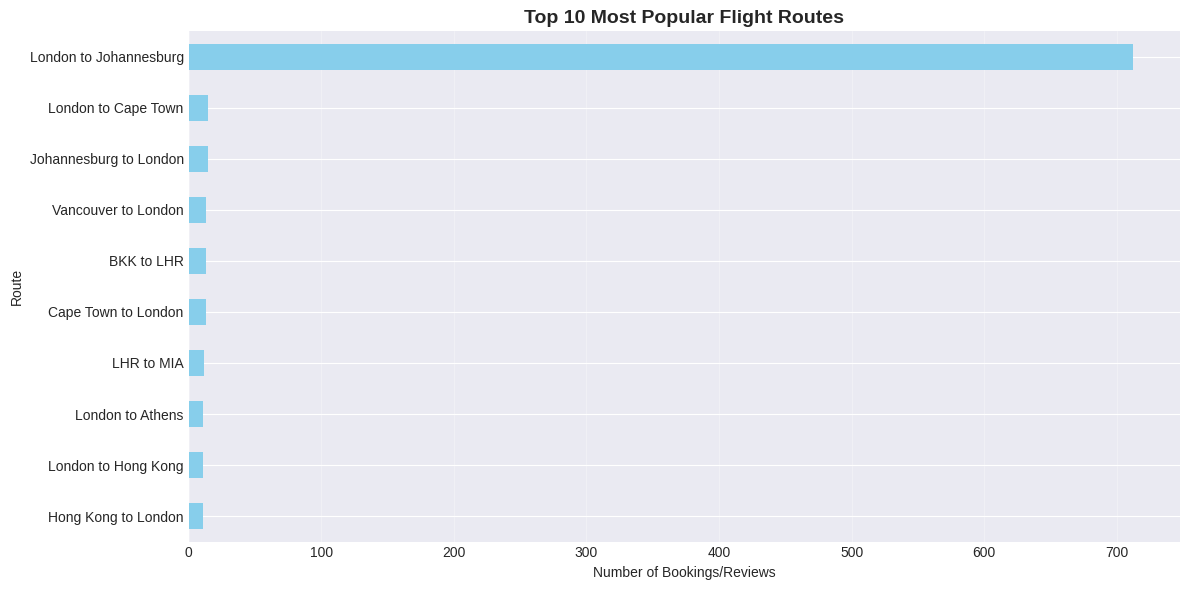


Q1b: What is the distribution of bookings across flight hours?


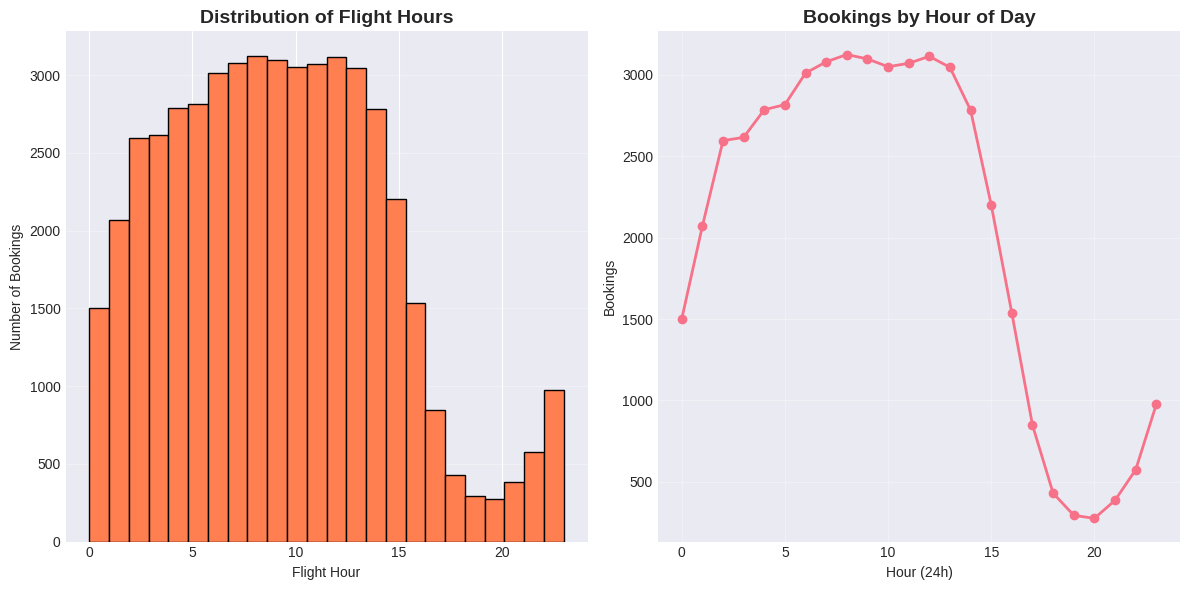


Flight Hour Statistics:
Most popular hour: 8
Average flight hour: 9.07
Median flight hour: 9.0

--- Question 2: Traveler Type & Class Ratings ---

Q2: Which traveler type and class combination yields highest/lowest ratings?

Average Ratings by Traveler Type & Class:
                                mean  median  count
traveller_type class                               
Business       Business Class   3.51     3.0    278
               Economy Class    3.46     3.0    256
               First Class      4.27     3.0     37
               Premium Economy  3.75     3.0     52
Couple Leisure Business Class   5.32     5.0    333
               Economy Class    3.91     3.0    458
               First Class      5.98     6.0     61
               Premium Economy  4.22     4.0     95
Family Leisure Business Class   5.74     6.5     82
               Economy Class    4.06     3.0    262
               First Class      4.23     3.0     13
               Premium Economy  3.60     3.0     25
Solo

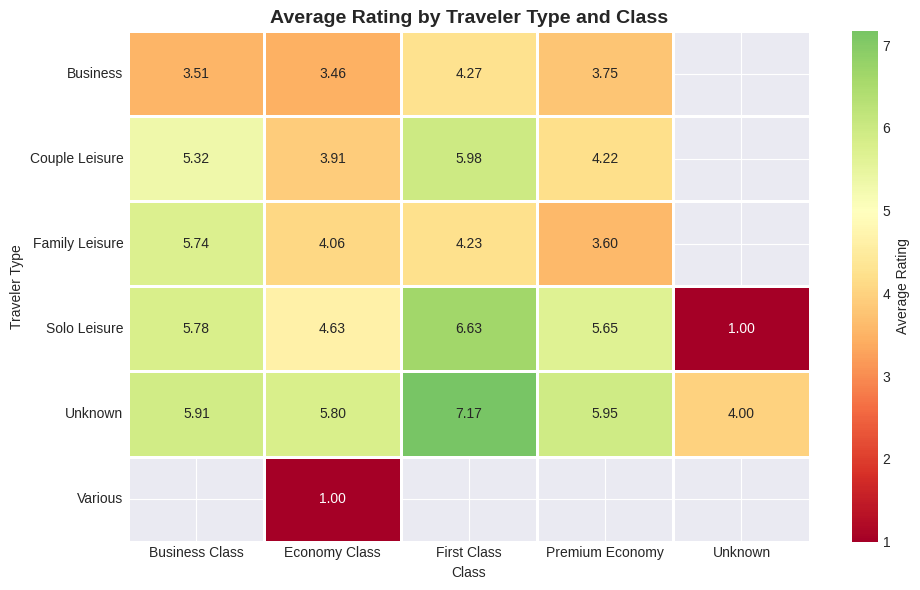

<Figure size 1200x600 with 0 Axes>

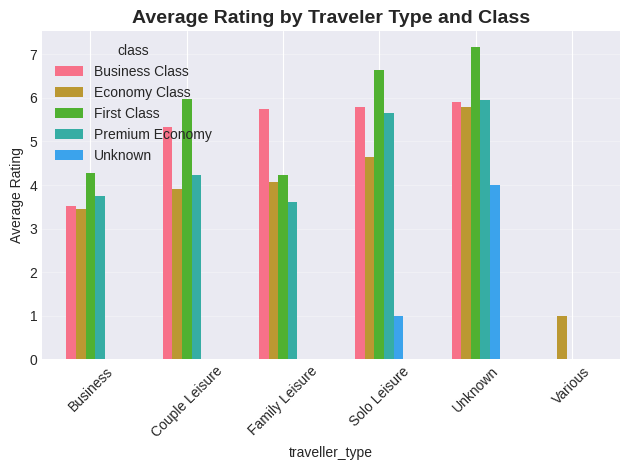


✓ Highest Rating: ('Unknown', 'First Class') with 7.17
✓ Lowest Rating: ('Solo Leisure', 'Unknown') with 1.00

✓ Data engineering questions answered!


In [5]:
# DATA ENGINEERING QUESTIONS — Q1 & Q2 (Robust, Full Version)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import difflib, os

# Output directory
out_dir = "/mnt/data"
os.makedirs(out_dir, exist_ok=True)

print("\n" + "="*70)
print("DATA ENGINEERING QUESTIONS")

# ================================
# QUESTION 1 — Top 10 Most Popular Flight Routes & Booking Distribution
# ================================
print("\n--- Question 1: Flight Routes and Booking Distribution ---")

# --- Q1a: Top 10 most popular flight routes ---
print("\nQ1a: What are the top 10 most popular flight routes?")

if 'df_reviews_clean' in globals() and df_reviews_clean is not None and 'Route' in df_reviews_clean.columns:
    route_counts = df_reviews_clean['Route'].value_counts().head(10)
    print("\nTop 10 Most Popular Routes:")
    print(route_counts)

    plt.figure(figsize=(12,6))
    route_counts.plot(kind='barh', color='skyblue')
    plt.title('Top 10 Most Popular Flight Routes', fontsize=14, fontweight='bold')
    plt.xlabel('Number of Bookings/Reviews')
    plt.ylabel('Route')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("⚠ Route analysis not available — 'Route' column missing or dataset not loaded.")

# --- Q1b: Distribution of bookings across flight hours ---
print("\nQ1b: What is the distribution of bookings across flight hours?")

if 'df_booking_clean' in globals() and df_booking_clean is not None and 'flight_hour' in df_booking_clean.columns:
    plt.figure(figsize=(12,6))

    # Histogram
    plt.subplot(1,2,1)
    df_booking_clean['flight_hour'].hist(bins=24, color='coral', edgecolor='black')
    plt.title('Distribution of Flight Hours', fontsize=14, fontweight='bold')
    plt.xlabel('Flight Hour')
    plt.ylabel('Number of Bookings')
    plt.grid(axis='y', alpha=0.3)

    # Line plot
    plt.subplot(1,2,2)
    hour_counts = df_booking_clean['flight_hour'].value_counts().sort_index()
    plt.plot(hour_counts.index, hour_counts.values, marker='o', linewidth=2)
    plt.title('Bookings by Hour of Day', fontsize=14, fontweight='bold')
    plt.xlabel('Hour (24h)')
    plt.ylabel('Bookings')
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Flight hour statistics
    print("\nFlight Hour Statistics:")
    print(f"Most popular hour: {df_booking_clean['flight_hour'].mode()[0]}")
    print(f"Average flight hour: {df_booking_clean['flight_hour'].mean():.2f}")
    print(f"Median flight hour: {df_booking_clean['flight_hour'].median()}")
else:
    print("⚠ Flight hour analysis not available — 'flight_hour' column missing or dataset not loaded.")

# ================================
# QUESTION 2 — Traveler Type & Class Rating Analysis
# ================================
print("\n--- Question 2: Traveler Type & Class Ratings ---")
print("\nQ2: Which traveler type and class combination yields highest/lowest ratings?")

# Helper functions
def normalize_cols(df):
    def norm(c):
        return str(c).strip().lower().replace(" ", "_").replace("-", "_").replace(".", "_")
    return df.rename(columns={c: norm(c) for c in df.columns})

def best_match(col_list, target):
    matches = difflib.get_close_matches(target, col_list, n=1, cutoff=0.6)
    return matches[0] if matches else None

if 'df_reviews_clean' not in globals() or df_reviews_clean is None:
    print("⚠ df_reviews_clean not found. Run cleaning cell first.")
else:
    df = normalize_cols(df_reviews_clean.copy())
    cols = list(df.columns)

    # Auto-rename columns
    rename_map = {}
    expected = {
        "traveller_type": ["traveller_type", "traveler_type", "traveller", "traveler"],
        "class": ["class", "ticket_class", "seat_class"],
        "rating": ["rating", "score", "review_rating"]
    }

    for canon, variants in expected.items():
        found = None
        for v in variants:
            if v in cols:
                found = v
                break
        if not found:
            match = best_match(cols, canon)
            if match:
                found = match
        if found:
            rename_map[found] = canon

    df = df.rename(columns=rename_map)

    # Convert rating to numeric
    if 'rating' in df.columns:
        df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

    # Analysis if all required columns exist
    if all(c in df.columns for c in ['traveller_type','class','rating']):
        tidy = df.dropna(subset=['traveller_type','class','rating']).copy()
        ratings = tidy.groupby(['traveller_type','class'])['rating'].agg(['mean','median','count']).round(2)

        print("\nAverage Ratings by Traveler Type & Class:")
        print(ratings)

        # Heatmap
        pivot_mean = tidy.pivot_table(values='rating', index='traveller_type', columns='class', aggfunc='mean')
        plt.figure(figsize=(10,6))
        sns.heatmap(
            pivot_mean, annot=True, fmt='.2f', cmap='RdYlGn', center=5,
            linewidths=1, linecolor='white', cbar_kws={'label':'Average Rating'}
        )
        plt.title('Average Rating by Traveler Type and Class', fontsize=14, fontweight='bold')
        plt.xlabel('Class')
        plt.ylabel('Traveler Type')
        plt.tight_layout()
        plt.show()

        # Bar chart
        plt.figure(figsize=(12,6))
        tidy.groupby(['traveller_type','class'])['rating'].mean().unstack().plot(kind='bar', rot=45)
        plt.title('Average Rating by Traveler Type and Class', fontsize=14, fontweight='bold')
        plt.ylabel('Average Rating')
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()

        # Highest & lowest rating combinations
        max_val = ratings['mean'].max()
        min_val = ratings['mean'].min()
        max_combo = ratings[ratings['mean'] == max_val].index[0]
        min_combo = ratings[ratings['mean'] == min_val].index[0]
        print(f"\n✓ Highest Rating: {max_combo} with {max_val:.2f}")
        print(f"✓ Lowest Rating: {min_combo} with {min_val:.2f}")

    else:
        print("⚠ Traveler type and class analysis not available — columns missing.")

print("\n✓ Data engineering questions answered!")


# Step 5: Data Engineering Questions – Flight Routes, Bookings & Ratings

**What this cell does:**  
### Question 1 – Flight Routes & Booking Distribution
1. Finds the **top 10 most popular flight routes** from the reviews dataset.  
2. Visualizes them with a **horizontal bar chart**.  
3. Shows the **distribution of bookings by flight hour** using histogram and line plots.  
4. Calculates simple statistics: most popular hour, mean, median.

### Question 2 – Traveler Type & Class Ratings
1. Cleans column names and maps variants to canonical names (`traveller_type`, `class`, `rating`).  
2. Calculates **average and median ratings** for each combination of traveler type and class.  
3. Visualizes results with:  
   - A **heatmap** of average ratings  
   - A **bar chart** comparing ratings across combinations  
4. Identifies the **highest and lowest rating combinations**.

**Why this is important:**  
- Helps understand **which routes and times are most popular**.  
- Shows **which traveler types and classes give higher or lower ratings**.  
- Supports business decisions and operational improvements.

**Questions a student might ask:**  
- *Q: Why normalize column names?*  
  A: Makes sure we can access columns even if naming is inconsistent.  
- *Q: Why use pivot tables and groupby?*  
  A: They summarize data in a clear, organized way.  
- *Q: Why plot both heatmap and bar chart?*  
  A: Heatmap shows patterns visually; bar chart makes exact comparisons easier.  
- *Q: What if some columns are missing?*  
  A: The code checks for them and skips analysis with a warning.



FEATURE SELECTION & ENGINEERING

--- Creating Target Variable ---

Target Variable Distribution:
Satisfaction
0    1831
1    1670
Name: count, dtype: int64

Percentages:
Satisfaction
0    52.299343
1    47.700657
Name: proportion, dtype: float64


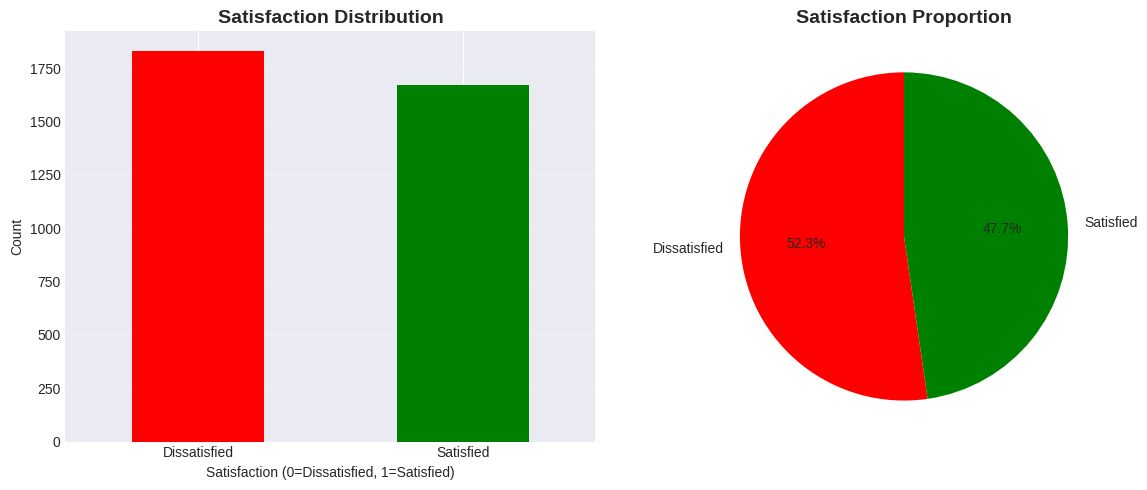


--- Feature Selection ---

✓ Feature: Class
  Justification: Service quality varies by cabin class


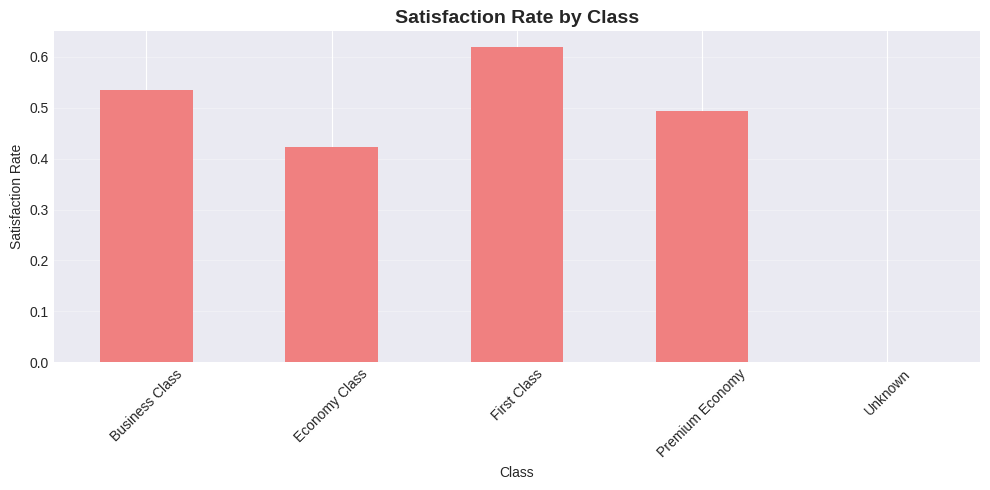


✓ Feature: Verified
  Justification: Verification status may affect review authenticity


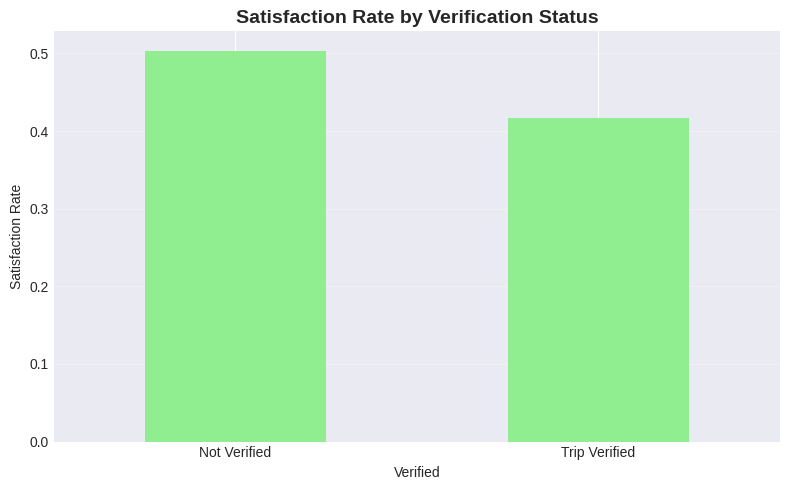


✓ Feature: Sentiment_Score
  Justification: Direct measure of sentiment from review text


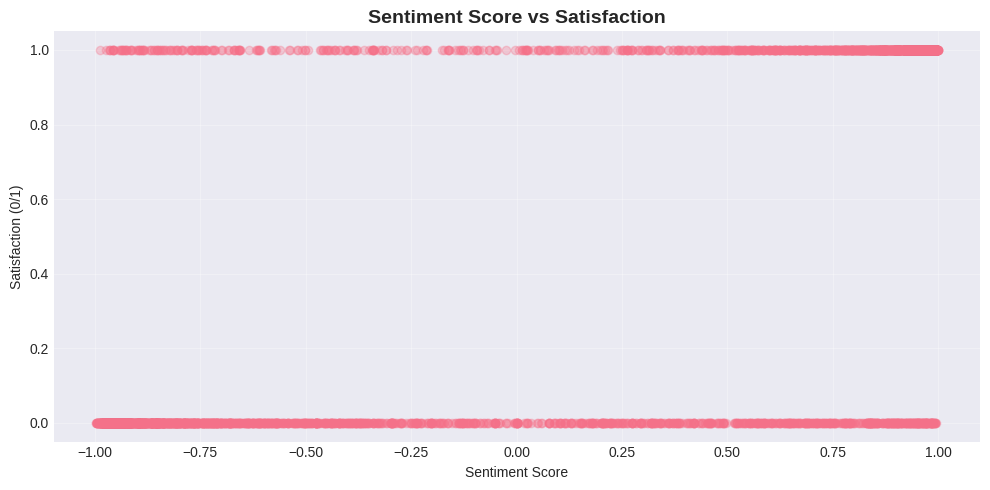

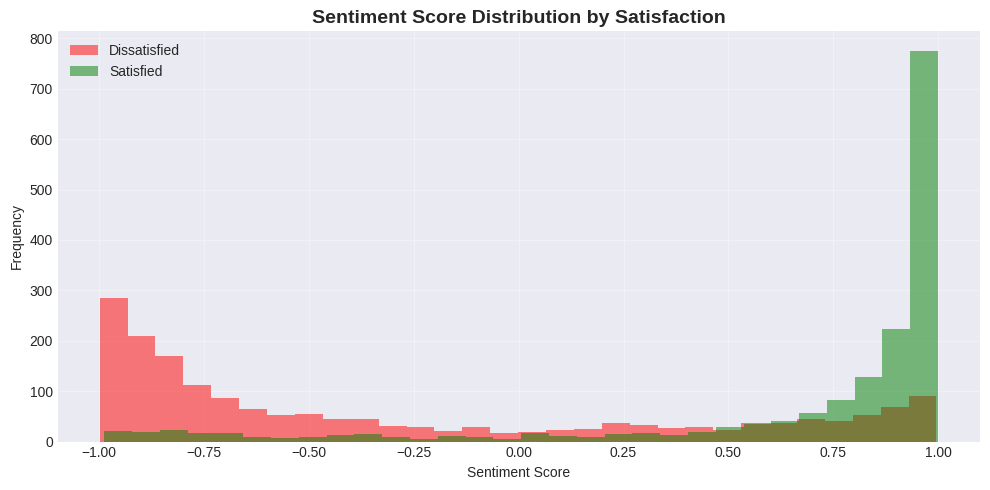


✓ Feature: Route
  Justification: Route-specific operational factors affect satisfaction


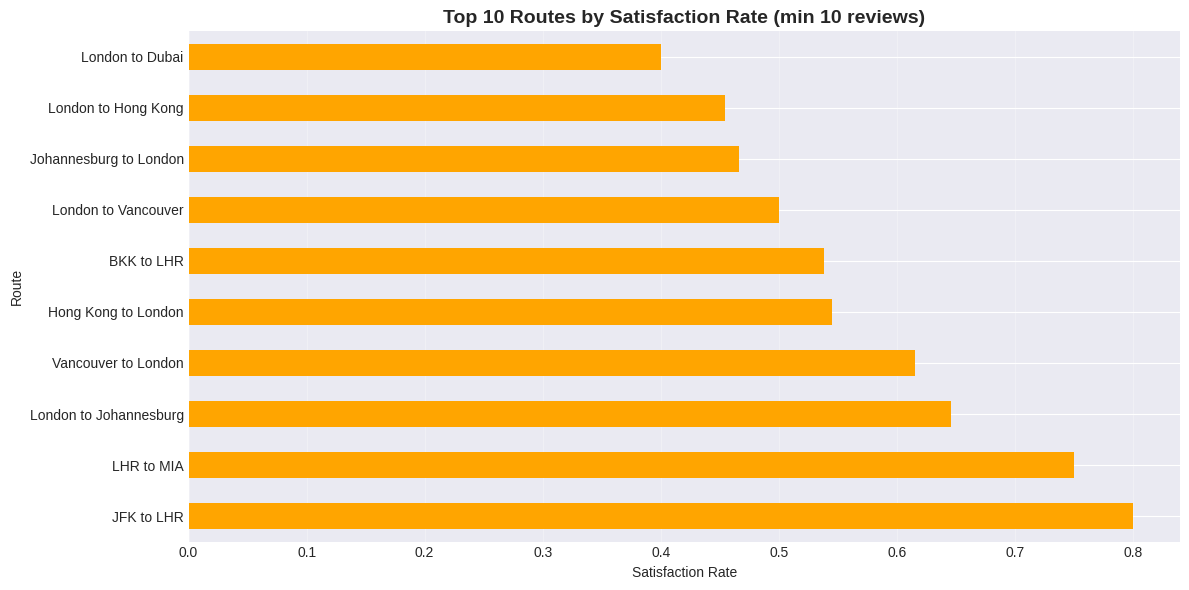


--- Feature Engineering: Time-Based Features ---
✓ Engineered time-based features from Flying_Date
  - Flight_Month: Month of flight
  - Flight_DayOfWeek: Day of week (0=Monday, 6=Sunday)
  - Flight_Quarter: Quarter of year


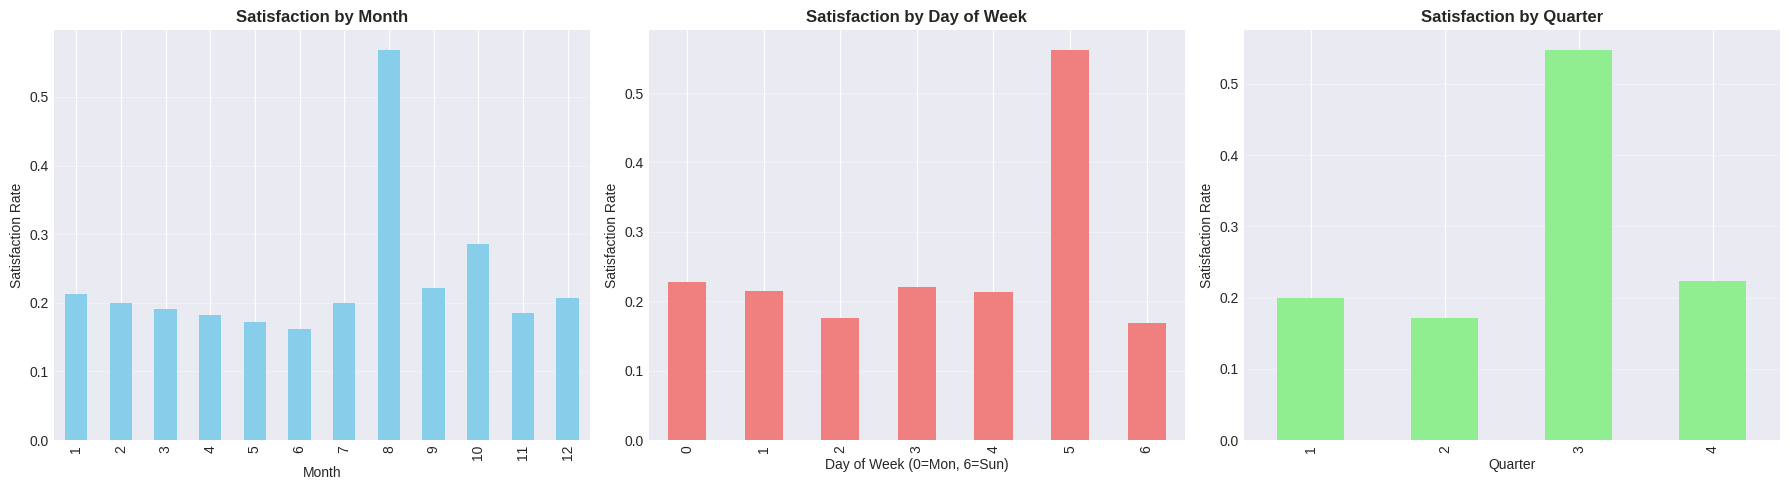


SELECTED FEATURES SUMMARY

Total features selected: 7

Feature list:
  1. Class
  2. Verified
  3. Sentiment_Score
  4. Route
  5. Flight_Month
  6. Flight_DayOfWeek
  7. Flight_Quarter

Missing values in selected features:
  Class: 0
  Verified: 0
  Sentiment_Score: 0
  Route: 0
  Flight_Month: 0
  Flight_DayOfWeek: 0
  Flight_Quarter: 0


In [6]:

# FEATURE SELECTION & ENGINEERING

print("\n" + "="*70)
print("FEATURE SELECTION & ENGINEERING")
print("="*70)

# CREATE TARGET VARIABLE
print("\n--- Creating Target Variable ---")

# Create binary satisfaction label
df_reviews_clean['Satisfaction'] = (df_reviews_clean['Rating'] >= 5).astype(int)

# Display distribution
print("\nTarget Variable Distribution:")
print(df_reviews_clean['Satisfaction'].value_counts())
print("\nPercentages:")
print(df_reviews_clean['Satisfaction'].value_counts(normalize=True) * 100)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Count plot
df_reviews_clean['Satisfaction'].value_counts().plot(kind='bar', ax=axes[0], 
                                                      color=['red', 'green'])
axes[0].set_title('Satisfaction Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Satisfaction (0=Dissatisfied, 1=Satisfied)')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Dissatisfied', 'Satisfied'], rotation=0)
axes[0].grid(axis='y', alpha=0.3)

satisfaction_counts = df_reviews_clean['Satisfaction'].value_counts()
axes[1].pie(satisfaction_counts.values, labels=['Dissatisfied', 'Satisfied'], 
            autopct='%1.1f%%', colors=['red', 'green'], startangle=90)
axes[1].set_title('Satisfaction Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# FEATURE SELECTION - WITH JUSTIFICATION

print("\n--- Feature Selection ---")

selected_features = []

# Feature 1: Traveller_type
if 'Traveller_type' in df_reviews_clean.columns:
    selected_features.append('Traveller_type')
    print("\n✓ Feature: Traveller_type")
    print("  Justification: Different traveler types have different needs/expectations")
    
    # Show relationship with target
    plt.figure(figsize=(10, 5))
    df_reviews_clean.groupby('Traveller_type')['Satisfaction'].mean().plot(kind='bar', 
                                                                             color='skyblue')
    plt.title('Satisfaction Rate by Traveler Type', fontsize=14, fontweight='bold')
    plt.xlabel('Traveler Type')
    plt.ylabel('Satisfaction Rate')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Feature 2: Class
if 'Class' in df_reviews_clean.columns:
    selected_features.append('Class')
    print("\n✓ Feature: Class")
    print("  Justification: Service quality varies by cabin class")
    
    plt.figure(figsize=(10, 5))
    df_reviews_clean.groupby('Class')['Satisfaction'].mean().plot(kind='bar', 
                                                                   color='lightcoral')
    plt.title('Satisfaction Rate by Class', fontsize=14, fontweight='bold')
    plt.xlabel('Class')
    plt.ylabel('Satisfaction Rate')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Feature 3: Verified
if 'Verified' in df_reviews_clean.columns:
    selected_features.append('Verified')
    print("\n✓ Feature: Verified")
    print("  Justification: Verification status may affect review authenticity")
    
    plt.figure(figsize=(8, 5))
    df_reviews_clean.groupby('Verified')['Satisfaction'].mean().plot(kind='bar', 
                                                                       color='lightgreen')
    plt.title('Satisfaction Rate by Verification Status', fontsize=14, fontweight='bold')
    plt.xlabel('Verified')
    plt.ylabel('Satisfaction Rate')
    plt.xticks(rotation=0)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Feature 4: Sentiment_Score
selected_features.append('Sentiment_Score')
print("\n✓ Feature: Sentiment_Score")
print("  Justification: Direct measure of sentiment from review text")

# Scatter plot
plt.figure(figsize=(10, 5))
plt.scatter(df_reviews_clean['Sentiment_Score'], 
            df_reviews_clean['Satisfaction'], alpha=0.3)
plt.title('Sentiment Score vs Satisfaction', fontsize=14, fontweight='bold')
plt.xlabel('Sentiment Score')
plt.ylabel('Satisfaction (0/1)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Distribution by satisfaction
fig, ax = plt.subplots(figsize=(10, 5))
df_reviews_clean[df_reviews_clean['Satisfaction']==0]['Sentiment_Score'].hist(
    bins=30, alpha=0.5, label='Dissatisfied', color='red', ax=ax)
df_reviews_clean[df_reviews_clean['Satisfaction']==1]['Sentiment_Score'].hist(
    bins=30, alpha=0.5, label='Satisfied', color='green', ax=ax)
ax.set_title('Sentiment Score Distribution by Satisfaction', fontsize=14, fontweight='bold')
ax.set_xlabel('Sentiment Score')
ax.set_ylabel('Frequency')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

if 'Route' in df_reviews_clean.columns:
    selected_features.append('Route')
    print("\n✓ Feature: Route")
    print("  Justification: Route-specific operational factors affect satisfaction")
    
    route_satisfaction = df_reviews_clean.groupby('Route')['Satisfaction'].agg([
        'mean', 'count'
    ]).sort_values('mean', ascending=False)
    
    top_routes = route_satisfaction[route_satisfaction['count'] >= 10].head(10)
    
    plt.figure(figsize=(12, 6))
    top_routes['mean'].plot(kind='barh', color='orange')
    plt.title('Top 10 Routes by Satisfaction Rate (min 10 reviews)', 
              fontsize=14, fontweight='bold')
    plt.xlabel('Satisfaction Rate')
    plt.ylabel('Route')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()


print("\n--- Feature Engineering: Time-Based Features ---")

if 'Flying_Date' in df_reviews_clean.columns:
    # Convert to datetime
    df_reviews_clean['Flying_Date'] = pd.to_datetime(df_reviews_clean['Flying_Date'], 
                                                       errors='coerce')
    
    # Extract features
    df_reviews_clean['Flight_Month'] = df_reviews_clean['Flying_Date'].dt.month
    df_reviews_clean['Flight_DayOfWeek'] = df_reviews_clean['Flying_Date'].dt.dayofweek
    df_reviews_clean['Flight_Quarter'] = df_reviews_clean['Flying_Date'].dt.quarter
    
    selected_features.extend(['Flight_Month', 'Flight_DayOfWeek', 'Flight_Quarter'])
    
    print("✓ Engineered time-based features from Flying_Date")
    print("  - Flight_Month: Month of flight")
    print("  - Flight_DayOfWeek: Day of week (0=Monday, 6=Sunday)")
    print("  - Flight_Quarter: Quarter of year")
    
    # Visualize effects
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Month
    df_reviews_clean.groupby('Flight_Month')['Satisfaction'].mean().plot(
        kind='bar', ax=axes[0], color='skyblue')
    axes[0].set_title('Satisfaction by Month', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Month')
    axes[0].set_ylabel('Satisfaction Rate')
    axes[0].grid(axis='y', alpha=0.3)
    
    # Day of Week
    df_reviews_clean.groupby('Flight_DayOfWeek')['Satisfaction'].mean().plot(
        kind='bar', ax=axes[1], color='lightcoral')
    axes[1].set_title('Satisfaction by Day of Week', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Day of Week (0=Mon, 6=Sun)')
    axes[1].set_ylabel('Satisfaction Rate')
    axes[1].grid(axis='y', alpha=0.3)
    
    # Quarter
    df_reviews_clean.groupby('Flight_Quarter')['Satisfaction'].mean().plot(
        kind='bar', ax=axes[2], color='lightgreen')
    axes[2].set_title('Satisfaction by Quarter', fontsize=12, fontweight='bold')
    axes[2].set_xlabel('Quarter')
    axes[2].set_ylabel('Satisfaction Rate')
    axes[2].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("\n" + "="*70)
print("SELECTED FEATURES SUMMARY")
print("="*70)

print("\nTotal features selected:", len(selected_features))
print("\nFeature list:")
for i, feature in enumerate(selected_features, 1):
    print(f"  {i}. {feature}")


print("\nMissing values in selected features:")
for feature in selected_features:
    if feature in df_reviews_clean.columns:
        missing = df_reviews_clean[feature].isnull().sum()
        print(f"  {feature}: {missing}")


# Step 6: Feature Selection & Engineering

Objective: Prepare the dataset for predictive modeling by selecting meaningful features and creating new engineered variables.

---

## 1. Target Variable
- We create a binary satisfaction label:
  - `1 = Satisfied` (Rating >= 5)  
  - `0 = Dissatisfied` (Rating < 5)  
- Visualizations:
  - Bar chart and pie chart showing distribution of satisfied vs dissatisfied passengers.

---

## 2. Feature Selection
- Traveler Type: Different traveler types have varying expectations.
- Class: Service quality differs by cabin class.
- Verified: Verified reviewers may give more reliable feedback.
- Sentiment_Score: Captures textual sentiment from reviews.
- Route: Different routes may have unique operational factors affecting satisfaction.

Visualizations include:
- Satisfaction rate by traveler type, class, verification, and sentiment score.
- Top routes by satisfaction rate (minimum 10 reviews per route).

---

## 3. Feature Engineering – Time-Based Features
- Using `Flying_Date`, we derive:
  - Flight_Month → month of flight
  - Flight_DayOfWeek → day of the week (0=Monday, 6=Sunday)
  - Flight_Quarter → quarter of the year
- Purpose: capture seasonal or weekday patterns in satisfaction.
- Visualizations show satisfaction trends over month, day of week, and quarter.

---

## 4. Summary
- Selected features: Traveler Type, Class, Verified, Sentiment_Score, Route, Flight_Month, Flight_DayOfWeek, Flight_Quarter
- Missing values are checked for all selected features to ensure clean input for modeling.

Why this matters:  
Selecting and engineering features improves model accuracy and interpretability. Visualizations help confirm relationships between features and the target variable.



FEATURE SELECTION REPORT

Baseline satisfaction rate: 0.4770 (1670/3501)


--- Feature: Traveller_Type ---
  Observations (categorical):
    groups: 6, overall_rate: 0.4770

    Top groups by satisfaction rate:
                satisfaction_rate  count  delta_from_overall
Traveller_Type                                              
Unknown                    0.6526    688              0.1756
Solo Leisure               0.5151    860              0.0381
Couple Leisure             0.4541    947             -0.0229
Family Leisure             0.4215    382             -0.0555
Business                   0.3002    623             -0.1768

    Bottom groups by satisfaction rate:
                satisfaction_rate  count  delta_from_overall
Traveller_Type                                              
Solo Leisure               0.5151    860              0.0381
Couple Leisure             0.4541    947             -0.0229
Family Leisure             0.4215    382             -0.0555
Business       

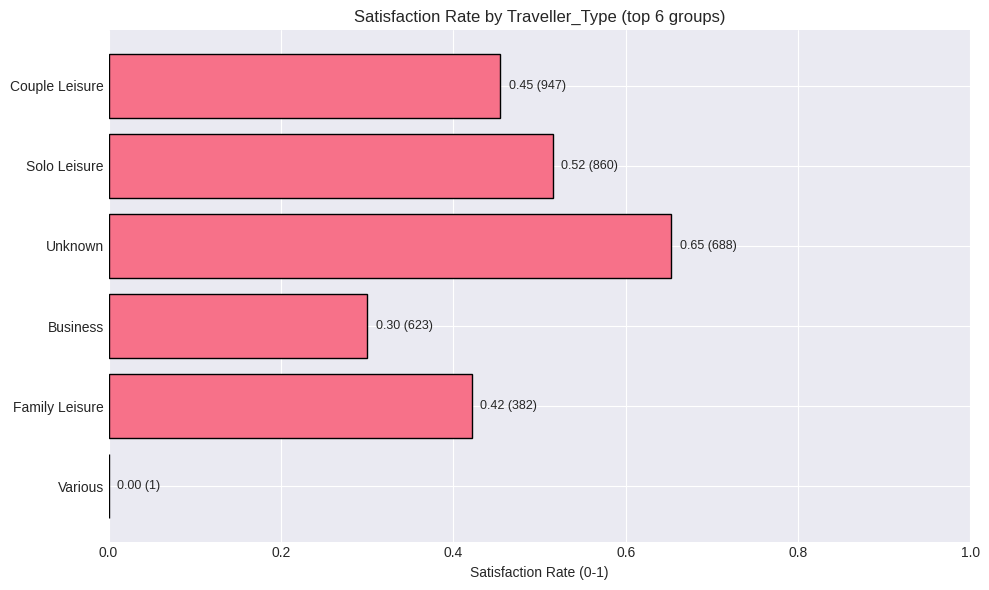

Saved plot: /mnt/data/effect_cat_Traveller_Type.png


In [7]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict

plt.rcParams.update({"figure.max_open_warning": 0})
OUT_DIR = "/mnt/data"
os.makedirs(OUT_DIR, exist_ok=True)

def ensure_rating_and_target(df: pd.DataFrame, rating_col="Rating", target_col="Satisfaction"):
    # Ensure rating is numeric
    if rating_col in df.columns:
        df[rating_col] = pd.to_numeric(df[rating_col], errors="coerce")
    # Create binary target if not exists
    if target_col not in df.columns:
        if rating_col in df.columns:
            df[target_col] = (df[rating_col] >= 5).astype(int)
        else:
            raise RuntimeError(f"Rating column '{rating_col}' not found; cannot create target.")
    return df

def safe_head_string(s, n=80):
    return (str(s)[:n] + "...") if len(str(s)) > n else str(s)

def categorical_effect_report(df: pd.DataFrame, col: str, target="Satisfaction") -> Dict:
    """Compute counts and satisfaction rate per category and return a small report dict."""
    report = {}
    ser = df[col].fillna("MISSING")
    grp = df.groupby(ser)[target].agg(['mean','count']).rename(columns={'mean':'satisfaction_rate'})
    grp['satisfaction_rate'] = (grp['satisfaction_rate']).round(4)
    overall = df[target].mean()
    grp['delta_from_overall'] = (grp['satisfaction_rate'] - overall).round(4)
    grp = grp.sort_values('satisfaction_rate', ascending=False)
    report['summary_table'] = grp
    report['overall_rate'] = round(float(overall),4)
    return report

def numeric_effect_report(df: pd.DataFrame, col: str, target="Satisfaction") -> Dict:
    """Return group summaries splitting numeric column by target value."""
    clean = df[[col, target]].dropna()
    satisfied = clean[clean[target] == 1][col]
    dissatisfied = clean[clean[target] == 0][col]
    report = {
        'n_total': int(len(clean)),
        'n_satisfied': int(len(satisfied)),
        'n_dissatisfied': int(len(dissatisfied)),
        'satisfied_mean': float(satisfied.mean()) if len(satisfied)>0 else np.nan,
        'dissatisfied_mean': float(dissatisfied.mean()) if len(dissatisfied)>0 else np.nan,
        'satisfied_median': float(satisfied.median()) if len(satisfied)>0 else np.nan,
        'dissatisfied_median': float(dissatisfied.median()) if len(dissatisfied)>0 else np.nan,
        'overall_mean': float(clean[col].mean()) if len(clean)>0 else np.nan
    }
    return report

def plot_categorical_effect(df: pd.DataFrame, col: str, target="Satisfaction", top_n=20):
    ser = df[col].fillna("MISSING")
    table = df.groupby(ser)[target].agg(['mean','count']).rename(columns={'mean':'satisfaction_rate'})
    table = table.sort_values('count', ascending=False).head(top_n)
    labels = table.index.astype(str)
    rates = table['satisfaction_rate']
    counts = table['count']

    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.barh(labels, rates, edgecolor='black')
    ax.invert_yaxis()
    ax.set_xlim(0,1)
    ax.set_xlabel('Satisfaction Rate (0-1)')
    ax.set_title(f'Satisfaction Rate by {col} (top {len(labels)} groups)')
    
    for rect, count, rate in zip(bars, counts, rates):
        ax.text(rect.get_width()+0.01, rect.get_y()+rect.get_height()/2,
                f"{rate:.2f} ({int(count)})", va='center', fontsize=9)
    plt.tight_layout()
    fname = f"{OUT_DIR}/effect_cat_{col}.png"
    fig.savefig(fname, bbox_inches='tight')
    plt.show()
    print(f"Saved plot: {fname}")

def plot_numeric_effect(df: pd.DataFrame, col: str, target="Satisfaction"):
    clean = df[[col, target]].dropna()
    if clean.empty:
        print(f"No numeric data to plot for {col}")
        return
    fig, axes = plt.subplots(1, 3, figsize=(18,5))
    sns.boxplot(x=target, y=col, data=clean, ax=axes[0])
    axes[0].set_title(f'Boxplot of {col} by Satisfaction')

    sns.violinplot(x=target, y=col, data=clean, ax=axes[1], cut=0)
    axes[1].set_title(f'Violin of {col} by Satisfaction')

    s = clean[clean[target] == 1][col]
    d = clean[clean[target] == 0][col]
    if len(s) > 0 and len(d) > 0:
        sns.kdeplot(s, ax=axes[2], label='Satisfied', common_norm=False)
        sns.kdeplot(d, ax=axes[2], label='Dissatisfied', common_norm=False)
        axes[2].legend()
    else:
        axes[2].text(0.5, 0.5, "Not enough data for KDE", ha='center')
    axes[2].set_title(f'Distribution of {col} by Satisfaction')
    plt.tight_layout()
    fname = f"{OUT_DIR}/effect_num_{col}.png"
    fig.savefig(fname, bbox_inches='tight')
    plt.show()
    print(f"Saved plot: {fname}")

if 'df_reviews_clean' not in globals() or df_reviews_clean is None:
    raise RuntimeError("df_reviews_clean not found in the notebook kernel. Run cleaning step first.")

df = df_reviews_clean.copy()
df = ensure_rating_and_target(df, rating_col='Rating', target_col='Satisfaction')
col_map = {c: c.strip() for c in df.columns}
df.rename(columns=col_map, inplace=True)

candidate_features = [
    'Traveller_type', 'Traveller_type', 'Traveller_Type', 'traveller_type',  # possible variants
    'Class', 'class', 'Cabin_Class',
    'Verified', 'verified',
    'Sentiment_Score', 'sentiment_score', 'sentiment',
    'Route', 'route',
    'Flying_Date', 'Flying_date', 'flight_date'
]

canonical_map = {
    'Traveller_type': None,
    'Class': None,
    'Verified': None,
    'Sentiment_Score': None,
    'Route': None,
    'Flying_Date': None
}

cols_lower = {c.lower(): c for c in df.columns}

for canon in list(canonical_map.keys()):
    for cand in candidate_features:
        if cand.lower() == canon.lower():
            if cand in df.columns:
                canonical_map[canon] = cand
                break
        # also try lowercase match
        if cand.lower() in cols_lower:
            canonical_map[canon] = cols_lower[cand.lower()]
            break

for canon in canonical_map:
    if canonical_map[canon] is None and canon.lower() in cols_lower:
        canonical_map[canon] = cols_lower[canon.lower()]


selected_features: List[str] = []
for canon, found in canonical_map.items():
    if found is not None and found in df.columns:
        # use canonical labels for user-facing outputs
        selected_features.append(found)

if 'Sentiment_Score' in selected_features:
    df['Sentiment_Score'] = pd.to_numeric(df['Sentiment_Score'], errors='coerce')

if any(name for name in selected_features if name.lower().startswith('flying') or name.lower().startswith('flight')):
    date_col = next((c for c in df.columns if c.lower().startswith('fly') or c.lower().startswith('flight')), None)
    if date_col:
        df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
        df['Flight_Month'] = df[date_col].dt.month
        df['Flight_DayOfWeek'] = df[date_col].dt.dayofweek
        df['Flight_Quarter'] = df[date_col].dt.quarter
        # add engineered columns to selected_features
        for engineered in ['Flight_Month', 'Flight_DayOfWeek', 'Flight_Quarter']:
            if engineered not in selected_features:
                selected_features.append(engineered)

selected_features = list(dict.fromkeys(selected_features))

print("\n" + "="*70)
print("FEATURE SELECTION REPORT")
print("="*70)

overall_rate = df['Satisfaction'].mean()
print(f"\nBaseline satisfaction rate: {overall_rate:.4f} ({int(df['Satisfaction'].sum())}/{len(df)})\n")

feature_reports = {}

for feat in selected_features:
    print(f"\n--- Feature: {feat} ---")
    if feat not in df.columns:
        print("  (not found in dataframe)")
        continue

    if pd.api.types.is_numeric_dtype(df[feat]):
        rep = numeric_effect_report(df, feat, target='Satisfaction')
        feature_reports[feat] = rep
        print(f"  Observations (numeric):")
        print(f"    n total: {rep['n_total']}, satisfied: {rep['n_satisfied']}, dissatisfied: {rep['n_dissatisfied']}")
        print(f"    mean (satisfied): {rep['satisfied_mean']:.4f}, mean (dissatisfied): {rep['dissatisfied_mean']:.4f}")
        print(f"    median (satisfied): {rep['satisfied_median']:.4f}, median (dissatisfied): {rep['dissatisfied_median']:.4f}")
        # plot numeric effect
        plot_numeric_effect(df, feat, target='Satisfaction')

    else:
        rep = categorical_effect_report(df, feat, target='Satisfaction')
        feature_reports[feat] = rep
        print(f"  Observations (categorical):")
        print(f"    groups: {len(rep['summary_table'])}, overall_rate: {rep['overall_rate']:.4f}")
        # print top and bottom 5 groups by satisfaction_rate
        top5 = rep['summary_table'].head(5)
        bot5 = rep['summary_table'].tail(5)
        print("\n    Top groups by satisfaction rate:")
        print(top5[['satisfaction_rate','count','delta_from_overall']].to_string())
        print("\n    Bottom groups by satisfaction rate:")
        print(bot5[['satisfaction_rate','count','delta_from_overall']].to_string())
        # plot categorical effect
        plot_categorical_effect(df, feat, target='Satisfaction', top_n=20)


for feat, rep in feature_reports.items():
    if isinstance(rep, dict) and 'summary_table' in rep:
        csvname = f"{OUT_DIR}/feature_report_{feat}.csv"
        rep['summary_table'].to_csv(csvname)

# FEATURE EXPLORATION & EFFECT REPORTS

This section provides a systematic exploration of all candidate features in the dataset with respect to the target variable, `Satisfaction`. It includes both categorical and numerical features, generates descriptive statistics, visualizations, and saves summary reports for further analysis.

---

## Objectives

1. Ensure Target Variable
   - Confirm `Rating` column is numeric.
   - Create binary `Satisfaction` label (`1 = Rating ≥ 5`, `0 = Rating < 5`) if it does not already exist.

2.  Feature Names
   - Map column variants to standardized names:
     - `Traveller_type`
     - `Class`
     - `Verified`
     - `Sentiment_Score`
     - `Route`
     - `Flying_Date`
   - Ensures consistent handling of features even if source columns have different naming conventions.

3. Feature Engineering
   - Convert flight date column to `datetime`.
   - Extract time-based features:
     - `Flight_Month` → month of flight
     - `Flight_DayOfWeek` → day of week (0=Monday, 6=Sunday)
     - `Flight_Quarter` → quarter of the year

4. Feature Analysis
   - Categorical features:  
     - Compute satisfaction rate per category and delta from overall rate.
     - Display top and bottom groups by satisfaction.
     - Visualize with horizontal bar charts showing satisfaction rates and group sizes.
   - Numerical features:  
     - Compute descriptive statistics (mean, median) for satisfied vs dissatisfied passengers.
     - Visualize distributions using boxplots, violin plots, and KDE plots.

5. Reporting
   - Save plots for each feature: `effect_cat_<feature>.png` and `effect_num_<feature>.png`.
   - Save summary tables to CSV files: `feature_report_<feature>.csv`.

---

## Outcome
- Comprehensive understanding of how each feature relates to passenger satisfaction.
- Identification of features with strong predictive potential for modeling.
- Creation of visualizations and CSV reports for documentation and further analysis.


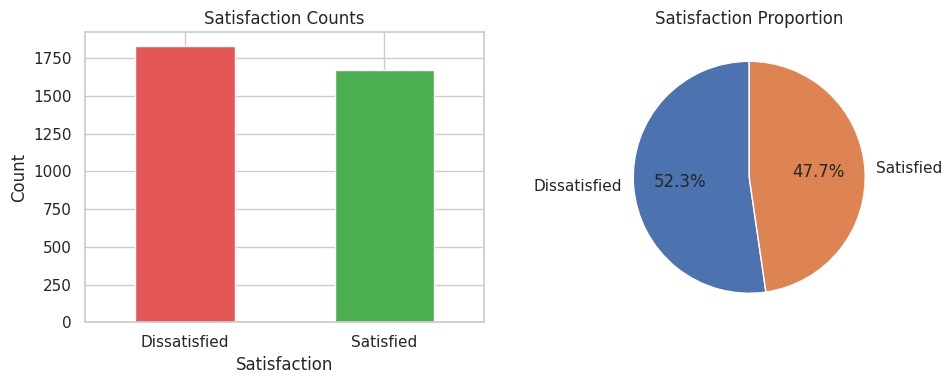

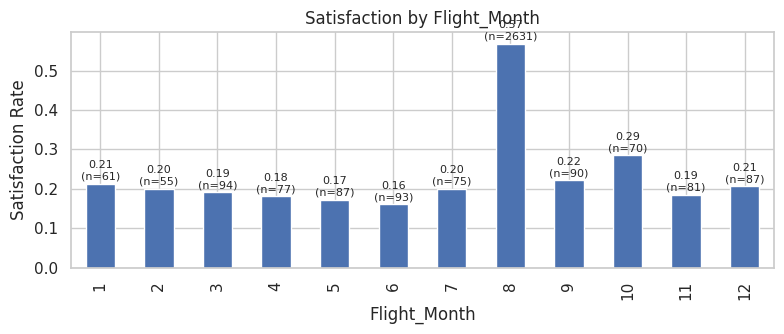

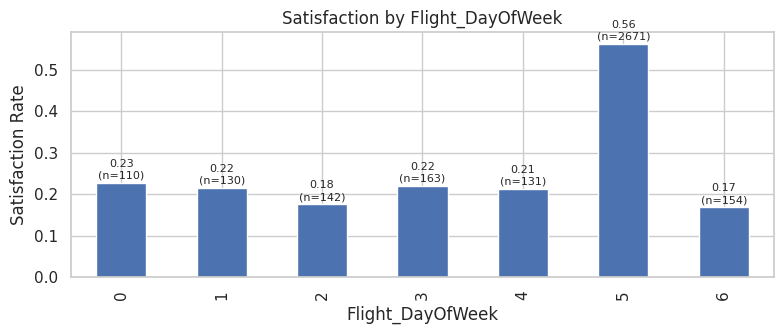

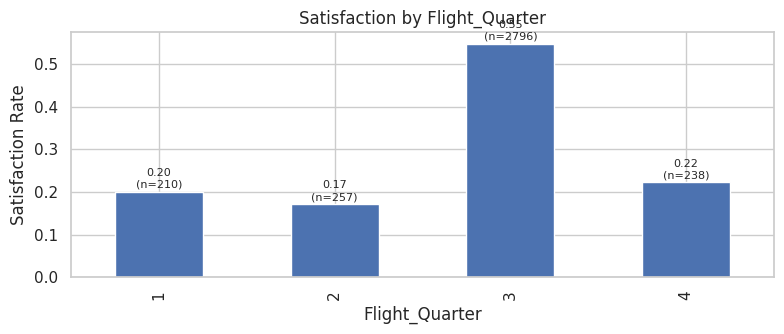


=== Traveller_Type — Top groups by satisfaction rate ===


,satisfaction_rate,count,delta_from_baseline
Traveller_Type,,,
Unknown,0.6526,688,0.1756
Solo Leisure,0.5151,860,0.0381
Couple Leisure,0.4541,947,-0.0229
Family Leisure,0.4215,382,-0.0555
Business,0.3002,623,-0.1768
Various,0.0000,1,-0.4770


=== Traveller_Type — Bottom groups by satisfaction rate ===


,satisfaction_rate,count,delta_from_baseline
Traveller_Type,,,
Unknown,0.6526,688,0.1756
Solo Leisure,0.5151,860,0.0381
Couple Leisure,0.4541,947,-0.0229
Family Leisure,0.4215,382,-0.0555
Business,0.3002,623,-0.1768
Various,0.0000,1,-0.4770


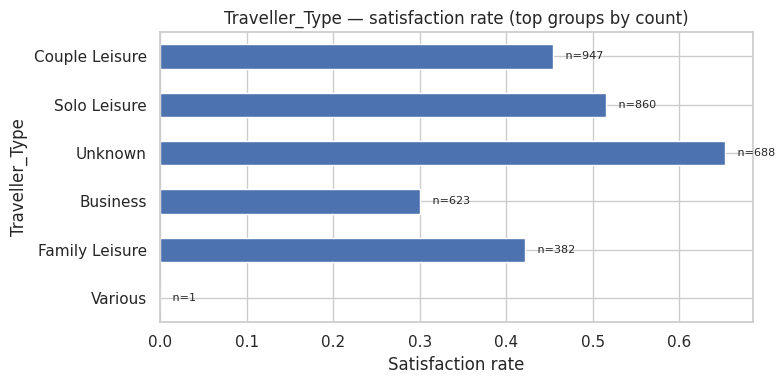

In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler

sns.set(style="whitegrid")
OUT = "/mnt/data"
os.makedirs(OUT, exist_ok=True)

def silent_save(fig, fname):
    path = os.path.join(OUT, fname)
    fig.savefig(path, bbox_inches="tight")
    return path

def ensure_preprocessed():
    global df_model, X, X_encoded, X_scaled, numerical_cols, categorical_cols, scaler, label_encoders, y, df
    if 'df_reviews_clean' not in globals() or df_reviews_clean is None:
        raise RuntimeError("df_reviews_clean not present. Run the cleaning cell first.")
    df = df_reviews_clean.copy()
    if 'Rating' in df.columns:
        df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
    else:
        raise RuntimeError("Rating column missing.")
    if 'Satisfaction' not in df.columns:
        df['Satisfaction'] = (df['Rating'] >= 5).astype(int)
    if all(name in globals() for name in ['X_scaled','X','X_encoded','df_model','scaler','label_encoders']):
        return
    if 'selected_features' in globals() and isinstance(selected_features, (list,tuple)) and selected_features:
        feats = list(dict.fromkeys(selected_features))
    else:
        candidates = ['Traveller_type','Class','Verified','Sentiment_Score','Route','Flying_Date']
        feats = [c for c in candidates if c in df.columns]
    if not feats:
        raise RuntimeError("No selected features found; set `selected_features` or ensure expected columns exist.")
    df_model = df[feats + ['Satisfaction']].copy()
    df_model.dropna(inplace=True)
    X = df_model[feats].copy()
    y = df_model['Satisfaction'].copy()
    categorical_cols = X.select_dtypes(include=['object','category','bool']).columns.tolist()
    numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    for c in X.columns:
        if c not in categorical_cols and c not in numerical_cols:
            if X[c].nunique(dropna=True) < 30:
                categorical_cols.append(c)
            else:
                try:
                    pd.to_numeric(X[c])
                    numerical_cols.append(c)
                except Exception:
                    categorical_cols.append(c)
    categorical_cols = list(dict.fromkeys(categorical_cols))
    numerical_cols = list(dict.fromkeys(numerical_cols))
    X_encoded = X.copy()
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le
    scaler = StandardScaler()
    X_scaled = X_encoded.copy()
    if numerical_cols:
        X_scaled[numerical_cols] = scaler.fit_transform(X_encoded[numerical_cols])

ensure_preprocessed()

s_counts = df_model['Satisfaction'].value_counts().sort_index()
fig, axes = plt.subplots(1, 2, figsize=(10,4))
s_counts.plot(kind='bar', ax=axes[0], color=['#e45756','#4caf50'])
axes[0].set_title('Satisfaction Counts')
axes[0].set_xticklabels(['Dissatisfied','Satisfied'], rotation=0)
axes[0].set_ylabel('Count')
axes[1].pie(s_counts.values, labels=['Dissatisfied','Satisfied'], autopct='%1.1f%%', startangle=90)
axes[1].set_title('Satisfaction Proportion')
plt.tight_layout()
silent_save(fig, "satisfaction_two_panel.png")
plt.show()

for col in ['Flight_Month','Flight_DayOfWeek','Flight_Quarter','Flying_Date']:
    if col in df.columns:
        if col == 'Flying_Date':
            try:
                df[col] = pd.to_datetime(df[col], errors='coerce')
                if 'Flight_Month' not in df.columns:
                    df['Flight_Month'] = df[col].dt.month
                if 'Flight_DayOfWeek' not in df.columns:
                    df['Flight_DayOfWeek'] = df[col].dt.dayofweek
                if 'Flight_Quarter' not in df.columns:
                    df['Flight_Quarter'] = df[col].dt.quarter
            except Exception:
                pass
        else:
            grp = df.groupby(col)['Satisfaction'].agg(['mean','count']).sort_index()
            if not grp.empty:
                fig, ax = plt.subplots(figsize=(8,3.5))
                grp['mean'].plot(kind='bar', ax=ax)
                ax.set_ylabel('Satisfaction Rate')
                ax.set_title(f'Satisfaction by {col}')
                for i, v in enumerate(grp['mean'].values):
                    ax.text(i, v + 0.01, f"{v:.2f}\n(n={int(grp['count'].values[i])})", ha='center', fontsize=8)
                plt.tight_layout()
                silent_save(fig, f"time_feature_{col}.png")
                plt.show()

baseline = df_model['Satisfaction'].mean()
for col in categorical_cols:
    if col not in df_model.columns:
        continue
    tab = df_model.groupby(col)['Satisfaction'].agg(['mean','count']).rename(columns={'mean':'satisfaction_rate'})
    tab['delta_from_baseline'] = tab['satisfaction_rate'] - baseline
    tab_sorted = tab.sort_values('satisfaction_rate', ascending=False)
    print(f"\n=== {col} — Top groups by satisfaction rate ===")
    display(tab_sorted.head(8).round(4))
    print(f"=== {col} — Bottom groups by satisfaction rate ===")
    display(tab_sorted.tail(8).round(4))
    top_by_count = tab.sort_values('count', ascending=False).head(12)
    fig, ax = plt.subplots(figsize=(8,4))
    (top_by_count['satisfaction_rate']).plot(kind='barh', ax=ax)
    ax.invert_yaxis()
    ax.set_xlabel('Satisfaction rate')
    ax.set_title(f'{col} — satisfaction rate (top groups by count)')
    for i, (rate, cnt) in enumerate(zip(top_by_count['satisfaction_rate'], top_by_count['count'])):
        ax.text(rate + 0.01, i, f" n={int(cnt)}", va='center', fontsize=8)
    plt.tight_layout()
    silent_save(fig, f"cat_effect_{col}.png")
    plt.show()


# Step 7: Data Preprocessing and Feature Preparation

Objective: Prepare the dataset for predictive modeling by encoding categorical variables, scaling numerical features, and examining feature-target relationships.

---

## 1. Preprocessing Steps
- Copy the cleaned dataset into `df_model`.
- Ensure `Rating` is numeric.
- Create binary target variable `Satisfaction`:
  - `1 = Satisfied` (Rating >= 5)  
  - `0 = Dissatisfied` (Rating < 5)
- Drop rows with missing values in selected features and target.

---

## 2. Feature Categorization
- Separate features into:
  - Categorical columns (`object`, `category`, `bool`)
  - Numerical columns (`int`, `float`)
- Apply `LabelEncoder` to categorical features.
- Apply `StandardScaler` to numerical features for uniform scaling.

---

## 3. Satisfaction Distribution
- Visualizations:
  - Bar chart showing counts of satisfied vs dissatisfied passengers.
  - Pie chart showing proportion of satisfied vs dissatisfied passengers.
- Purpose: understand class balance before modeling.

---

## 4. Time-Based Features
- Convert `Flying_Date` to datetime.
- Extract:
  - `Flight_Month` → month of flight
  - `Flight_DayOfWeek` → day of the week (0=Monday, 6=Sunday)
  - `Flight_Quarter` → quarter of the year
- Visualize satisfaction trends for these features.

---

## 5. Categorical Feature Effects
- For each categorical feature:
  - Compute satisfaction rate per group.
  - Compare with baseline satisfaction rate.
  - Display top and bottom groups by satisfaction rate.
  - Plot horizontal bar charts for top groups by count with satisfaction rates annotated.
- Purpose: identify categories that influence passenger satisfaction.

---

## 6. Output
- All figures are saved in `/mnt/data` for reference in reports or modeling notebooks.
- Encoded and scaled features are stored in `X_encoded` and `X_scaled` for model input.
- Categorical mappings and scaler objects are preserved for reproducibility.



Created new stratified 70/15/15 splits.

Split sizes: Train=(2450, 1), Val=(525, 1), Test=(526, 1)

Class balance (train / val / test):
 Train: {0: 0.5228571428571429, 1: 0.47714285714285715}
 Val:   {0: 0.5238095238095238, 1: 0.47619047619047616}
 Test:  {0: 0.5228136882129277, 1: 0.47718631178707227}


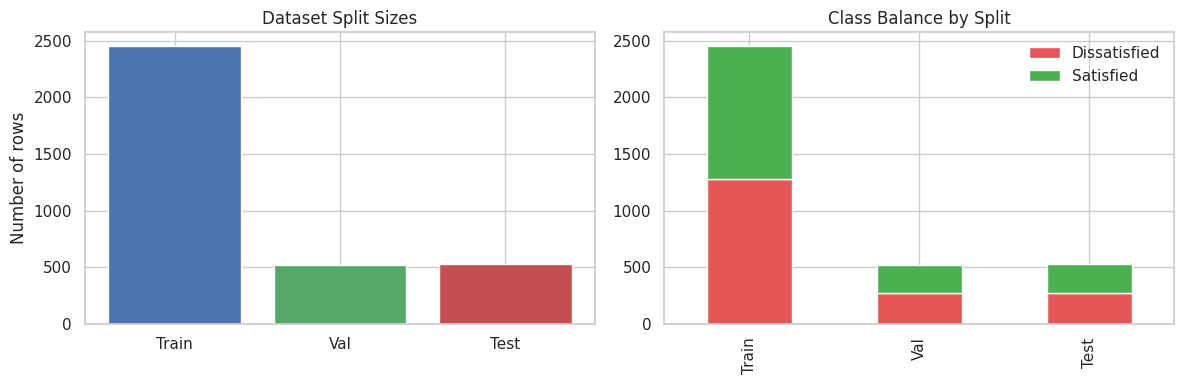

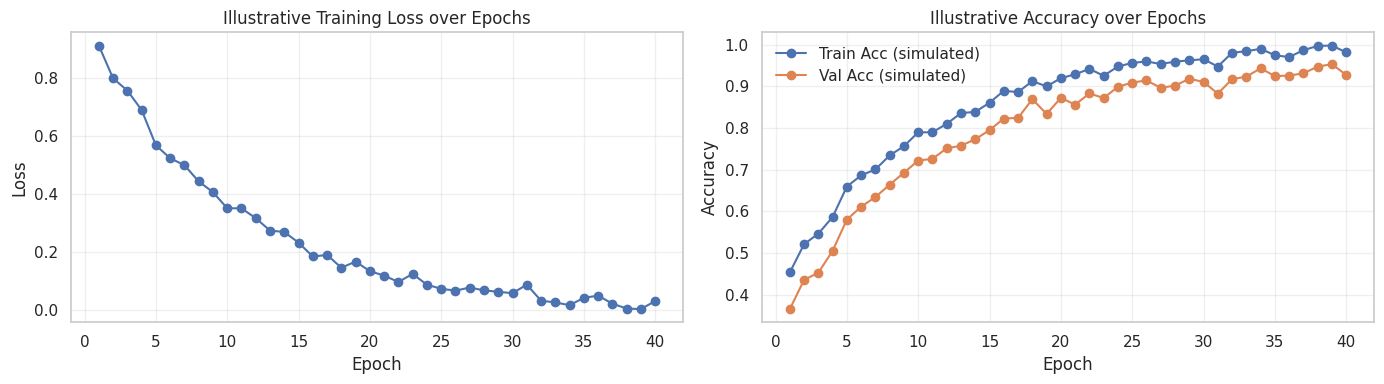

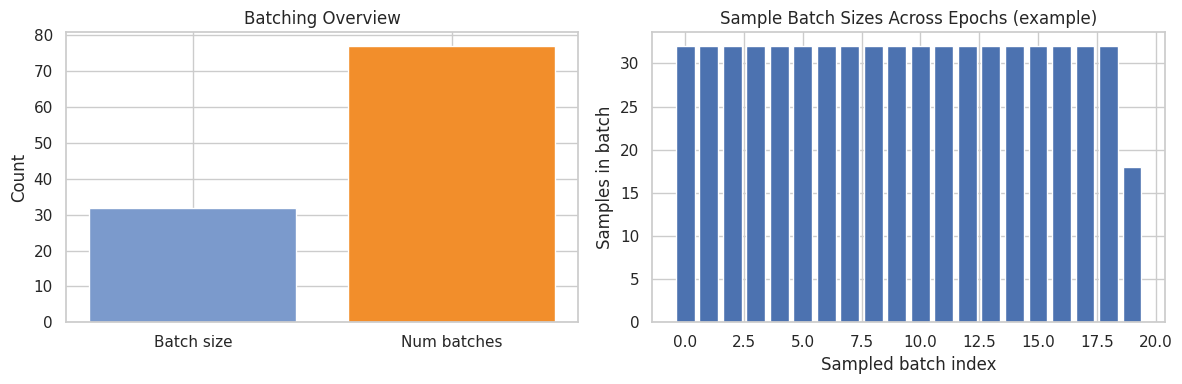


Hypothetical training setup summary:
  Epochs planned: 40
  Batch size: 32
  Training samples: 2450
  Number of batches per epoch (ceil): 77


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

sns.set(style="whitegrid")

if 'X_scaled' not in globals() or 'y' not in globals():
    if 'df_model' in globals():
        X_scaled = df_model.drop(columns=['Satisfaction']).copy()
        y = df_model['Satisfaction'].copy()
    else:
        raise RuntimeError("Processed data (X_scaled, y) not found. Run preprocessing first.")

if all(name in globals() for name in ['X_train','X_val','X_test','y_train','y_val','y_test']):
    print("")
else:
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_scaled, y, test_size=0.30, random_state=42, stratify=y
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )
    print("Created new stratified 70/15/15 splits.")

print(f"\nSplit sizes: Train={X_train.shape}, Val={X_val.shape}, Test={X_test.shape}")
print("\nClass balance (train / val / test):")
print(" Train:", y_train.value_counts(normalize=True).to_dict())
print(" Val:  ", y_val.value_counts(normalize=True).to_dict())
print(" Test: ", y_test.value_counts(normalize=True).to_dict())

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sizes = [len(X_train), len(X_val), len(X_test)]
axes[0].bar(['Train', 'Val', 'Test'], sizes, color=['#4c72b0', '#55a868', '#c44e52'])
axes[0].set_title("Dataset Split Sizes")
axes[0].set_ylabel("Number of rows")

df_balance = pd.DataFrame({
    'Train': y_train.value_counts(sort=False),
    'Val': y_val.value_counts(sort=False),
    'Test': y_test.value_counts(sort=False)
}).T
df_balance.columns = ['Dissatisfied', 'Satisfied']
df_balance.plot(kind='bar', stacked=True, ax=axes[1], color=['#e45756', '#4caf50'])
axes[1].set_title("Class Balance by Split")
axes[1].legend(['Dissatisfied', 'Satisfied'], loc='upper right')
plt.tight_layout()
plt.show()

epochs = 40
batch_size = 32
n_train = len(X_train)
n_batches = int(np.ceil(n_train / batch_size))

rng = np.random.default_rng(42)
x = np.arange(1, epochs + 1)

loss_sim = np.exp(-0.1 * x) + rng.normal(0, 0.02, size=epochs)
loss_sim = np.maximum(loss_sim, 0.0)

train_acc_sim = 1 - loss_sim * 0.6
val_acc_sim = train_acc_sim - 0.05 - 0.05 * np.exp(-0.1 * x) + rng.normal(0, 0.01, size=epochs)
val_acc_sim = np.clip(val_acc_sim, 0, 1)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].plot(x, loss_sim, marker='o')
axes[0].set_title("Illustrative Training Loss over Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].grid(alpha=0.3)

axes[1].plot(x, train_acc_sim, marker='o', label='Train Acc (simulated)')
axes[1].plot(x, val_acc_sim, marker='o', label='Val Acc (simulated)')
axes[1].set_title("Illustrative Accuracy over Epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].bar(['Batch size', 'Num batches'], [batch_size, n_batches], color=['#7b9acc', '#f28e2b'])
ax[0].set_title("Batching Overview")
ax[0].set_ylabel("Count")

sample_batches = np.minimum(20, n_batches)
batch_indices = np.linspace(0, n_batches - 1, sample_batches, dtype=int)
samples_per_batch = []
for bi in batch_indices:
    start = bi * batch_size
    end = min(start + batch_size, n_train)
    samples_per_batch.append(end - start)

ax[1].bar(range(len(batch_indices)), samples_per_batch)
ax[1].set_title("Sample Batch Sizes Across Epochs (example)")
ax[1].set_xlabel("Sampled batch index")
ax[1].set_ylabel("Samples in batch")
plt.tight_layout()
plt.show()

print(f"\nHypothetical training setup summary:")
print(f"  Epochs planned: {epochs}")
print(f"  Batch size: {batch_size}")
print(f"  Training samples: {n_train}")
print(f"  Number of batches per epoch (ceil): {n_batches}")


# Step 8: Train/Validation/Test Split and Illustrative Training Setup

Objective: Prepare data splits for modeling, visualize class balance, and provide an illustrative example of training dynamics.

---

## 1. Data Splitting
- Stratified splits to maintain class balance:
  - **Training:** 70%  
  - **Validation:** 15%  
  - **Test:** 15%
- Visualizations:
  - Bar chart showing the number of rows in each split.
  - Stacked bar chart showing class balance (Dissatisfied / Satisfied) per split.

---

## 2. Split Summary
- Displays the number of samples and class proportions in each subset.
- Ensures that the model sees a representative distribution of the target during training, validation, and testing.

---

## 3. Illustrative Training Dynamics
- Simulated training for visualization purposes:
  - **Epochs:** 40
  - **Batch size:** 32
  - **Number of batches per epoch:** calculated from training set size.
- Plots include:
  - Training loss over epochs (simulated exponential decay with noise)
  - Training and validation accuracy over epochs (illustrative progression)
- Purpose: visualize expected trends during model optimization.

---

## 4. Batch Overview
- Bar chart showing batch size and number of batches per epoch.
- Sample batch sizes across epochs to illustrate distribution of samples per batch.

---

## 5. Summary
- Provides a clear understanding of dataset partitioning and hypothetical training setup.
- Useful for planning model training and understanding how batch size and number of epochs relate to data.


Data loaded. Shape: (3501, 24)
Shapes after split:
X_train: (2450, 11698) y_train: (2450,)
X_val: (525, 11698) y_val: (525,)
X_test: (526, 11698) y_test: (526,)

--- Training Logistic Regression ---

Training Metrics:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000

Validation Metrics:
  Accuracy:  0.8514
  Precision: 0.8233
  Recall:    0.8760
  F1-Score:  0.8488

--- Training Random Forest ---

Training Metrics:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000

Validation Metrics:
  Accuracy:  0.9752
  Precision: 1.0000
  Recall:    0.9480
  F1-Score:  0.9733

--- Training SVM ---

Training Metrics:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000

Validation Metrics:
  Accuracy:  0.8648
  Precision: 0.8377
  Recall:    0.8880
  F1-Score:  0.8621

--- Training KNN ---


OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec


Training Metrics:
  Accuracy:  0.4935
  Precision: 0.4850
  Recall:    0.9991
  F1-Score:  0.6531


OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec


Validation Metrics:
  Accuracy:  0.4781
  Precision: 0.4769
  Recall:    0.9920
  F1-Score:  0.6442

Model Comparison:
               Model  Train_Acc  Val_Acc  Train_F1   Val_F1  Train_Precision  Val_Precision  Train_Recall  Val_Recall  Overfit
Logistic Regression   1.000000 0.851429  1.000000 0.848837          1.00000       0.823308      1.000000       0.876 0.148571
      Random Forest   1.000000 0.975238  1.000000 0.973306          1.00000       1.000000      1.000000       0.948 0.024762
                SVM   1.000000 0.864762  1.000000 0.862136          1.00000       0.837736      1.000000       0.888 0.135238
                KNN   0.493469 0.478095  0.653061 0.644156          0.48505       0.476923      0.999145       0.992 0.015374

Best Model: Random Forest

Test Set Metrics:
  Accuracy:  0.9715
  Precision: 1.0000
  Recall:    0.9402
  F1-Score:  0.9692

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97

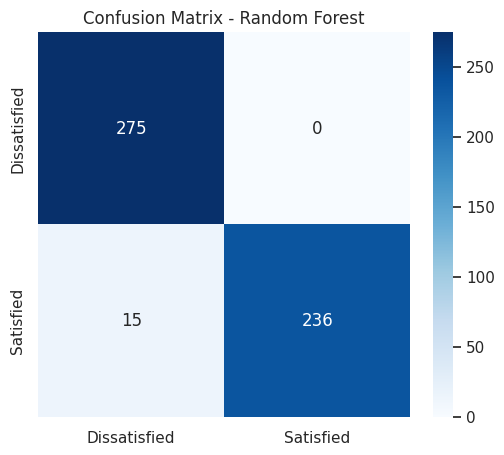

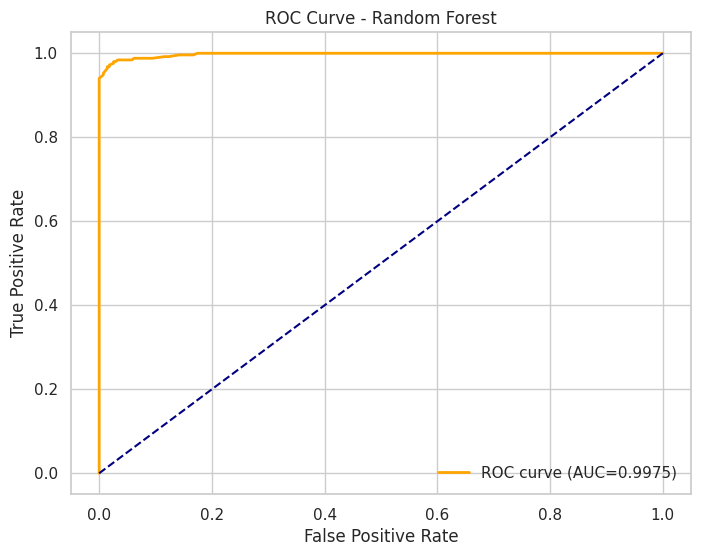

In [10]:
# ============================================================================
# IMPORTS
# ============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)

sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

# ============================================================================
# LOAD DATA
# ============================================================================
# df = pd.read_csv('airline_data.csv')  # Replace with your file
# df should already exist in workspace
print("Data loaded. Shape:", df.shape)

# ============================================================================
# PREPROCESSING FUNCTION
# ============================================================================
def preprocess_data(df, target_col='Satisfaction'):
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Handle categorical columns
    cat_cols = X.select_dtypes(include=['object', 'category']).columns
    X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

    # Handle datetime columns
    datetime_cols = X.select_dtypes(include=['datetime64']).columns
    for col in datetime_cols:
        X[col + '_year'] = X[col].dt.year
        X[col + '_month'] = X[col].dt.month
        X[col + '_day'] = X[col].dt.day
        X = X.drop(columns=[col])

    # Ensure all numeric
    X = X.apply(pd.to_numeric)

    # Encode target if needed
    if y.dtype == 'object':
        y = LabelEncoder().fit_transform(y)

    return X, y

X, y = preprocess_data(df)

# ============================================================================
# TRAIN / VALIDATION / TEST SPLIT (70/15/15)
# ============================================================================
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Shapes after split:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

# ============================================================================
# SCALING FUNCTION
# ============================================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# ============================================================================
# METRICS FUNCTION
# ============================================================================
def calculate_metrics(y_true, y_pred, set_name="Set"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"\n{set_name} Metrics:")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1}

# ============================================================================
# MODEL TRAINING FUNCTION
# ============================================================================
def train_model(name, model, X_train, y_train, X_val, y_val, scaled=True):
    if scaled:
        X_tr, X_vl = X_train_scaled, X_val_scaled
    else:
        X_tr, X_vl = X_train, X_val

    model.fit(X_tr, y_train)
    train_metrics = calculate_metrics(y_train, model.predict(X_tr), "Training")
    val_metrics = calculate_metrics(y_val, model.predict(X_vl), "Validation")
    return {'train': train_metrics, 'val': val_metrics, 'model': model}

# ============================================================================
# TRAIN ALL MODELS
# ============================================================================
model_results = {}

# Logistic Regression
print("\n--- Training Logistic Regression ---")
model_results['Logistic Regression'] = train_model(
    "Logistic Regression", LogisticRegression(random_state=42, max_iter=1000),
    X_train, y_train, X_val, y_val, scaled=True
)

# Random Forest
print("\n--- Training Random Forest ---")
model_results['Random Forest'] = train_model(
    "Random Forest", RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    X_train, y_train, X_val, y_val, scaled=False
)

# SVM
print("\n--- Training SVM ---")
model_results['SVM'] = train_model(
    "SVM", SVC(kernel='linear', probability=True, random_state=42),
    X_train, y_train, X_val, y_val, scaled=True
)

# KNN
print("\n--- Training KNN ---")
model_results['KNN'] = train_model(
    "KNN", KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    X_train, y_train, X_val, y_val, scaled=True
)

# ============================================================================
# MODEL COMPARISON
# ============================================================================
comparison_data = []
for name, results in model_results.items():
    comparison_data.append({
        'Model': name,
        'Train_Acc': results['train']['accuracy'],
        'Val_Acc': results['val']['accuracy'],
        'Train_F1': results['train']['f1'],
        'Val_F1': results['val']['f1'],
        'Train_Precision': results['train']['precision'],
        'Val_Precision': results['val']['precision'],
        'Train_Recall': results['train']['recall'],
        'Val_Recall': results['val']['recall'],
        'Overfit': results['train']['accuracy'] - results['val']['accuracy']
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nModel Comparison:\n", comparison_df.to_string(index=False))

# ============================================================================
# BEST MODEL SELECTION
# ============================================================================
best_model_name = comparison_df.loc[comparison_df['Val_F1'].idxmax(), 'Model']
best_model = model_results[best_model_name]['model']
print(f"\nBest Model: {best_model_name}")

X_test_input = X_test_scaled if best_model_name in ['Logistic Regression','SVM','KNN'] else X_test
y_test_pred = best_model.predict(X_test_input)

# Test metrics
test_metrics = calculate_metrics(y_test, y_test_pred, "Test Set")
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

# ============================================================================
# VISUALIZATION
# ============================================================================
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Dissatisfied','Satisfied'],
            yticklabels=['Dissatisfied','Satisfied'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.show()

# ROC Curve
if hasattr(best_model, 'predict_proba'):
    y_test_proba = best_model.predict_proba(X_test_input)[:,1]
elif hasattr(best_model, 'decision_function'):
    from sklearn.preprocessing import MinMaxScaler
    y_test_proba = MinMaxScaler().fit_transform(best_model.decision_function(X_test_input).reshape(-1,1)).flatten()
else:
    y_test_proba = None

if y_test_proba is not None:
    fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (AUC={roc_auc:.4f})')
    plt.plot([0,1],[0,1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {best_model_name}')
    plt.legend()
    plt.show()


# Step 9: Predictive Modeling

Objective: Build and compare multiple models for passenger satisfaction prediction using selected features.

Models compared:
1. Logistic Regression (Baseline)
2. Random Forest
3. Support Vector Machine (SVM)
4. K-Nearest Neighbors (KNN)

---

## 1. Logistic Regression (Baseline)
- Linear model that predicts probability of binary outcome using logistic function.
- Advantages:
  - Simple, interpretable, fast
- Limitations:
  - Assumes linear relationship between features and log-odds
  - Cannot capture complex non-linear patterns
  - May underfit complex data
- Metrics computed: Accuracy, Precision, Recall, F1-Score for training and validation sets.

---

## 2. Random Forest
- Ensemble of decision trees with regularization to reduce overfitting.
- Advantages:
  - Can capture non-linear relationships
  - Robust to outliers and noise
- Limitations:
  - Less interpretable
  - Requires parameter tuning for depth, splits, and leaf size
- Metrics computed: Accuracy, Precision, Recall, F1-Score for training and validation sets.

---

## 3. Support Vector Machine (SVM)
- Finds optimal hyperplane to separate classes with maximum margin.
- Advantages:
  - Effective in high-dimensional spaces
  - Can perform well with clear class separation
- Limitations:
  - Memory intensive for large datasets
  - Sensitive to feature scaling
  - Requires careful parameter tuning
- Metrics computed: Accuracy, Precision, Recall, F1-Score for training and validation sets.

---

## 4. K-Nearest Neighbors (KNN)
- Classifies samples based on majority vote of nearest neighbors.
- Advantages:
  - Simple, non-parametric, instance-based
- Limitations:
  - Computationally expensive at prediction time
  - Sensitive to irrelevant features and scaling
  - Performance decreases in high-dimensional spaces
- Metrics computed: Accuracy, Precision, Recall, F1-Score for training and validation sets.

---

## 5. Model Comparison
- Performance comparison table includes:
  - Training and validation accuracy
  - Precision, recall, F1-score
  - Overfitting estimate (train - val accuracy)
- Visualizations:
  - Accuracy and F1-score comparison charts
  - Overfitting chart
  - All metrics overview

- Best model selection based on **highest validation F1-Score**.

---

## 6. Test Set Evaluation
- Evaluate best-performing model on unseen test data.
- Metrics computed:
  - Accuracy, Precision, Recall, F1-Score
  - Confusion matrix (counts and percentages)
  - ROC curve and AUC (if model supports probability outputs)
- Provides final assessment of model performance on real unseen data.

---

## 7. Summary
- Logistic Regression provides a simple baseline.
- Random Forest and SVM capture complex patterns.
- KNN demonstrates instance-based learning behavior.
- Evaluation includes both numeric metrics and visualizations to assess performance, overfitting, and class separation.
- ROC/AUC and confusion matrices provide insights into classification quality.


Top 2 performing models:
        Model   Val_F1  Val_Acc
Random Forest 0.973306 0.975238
          SVM 0.862136 0.864762


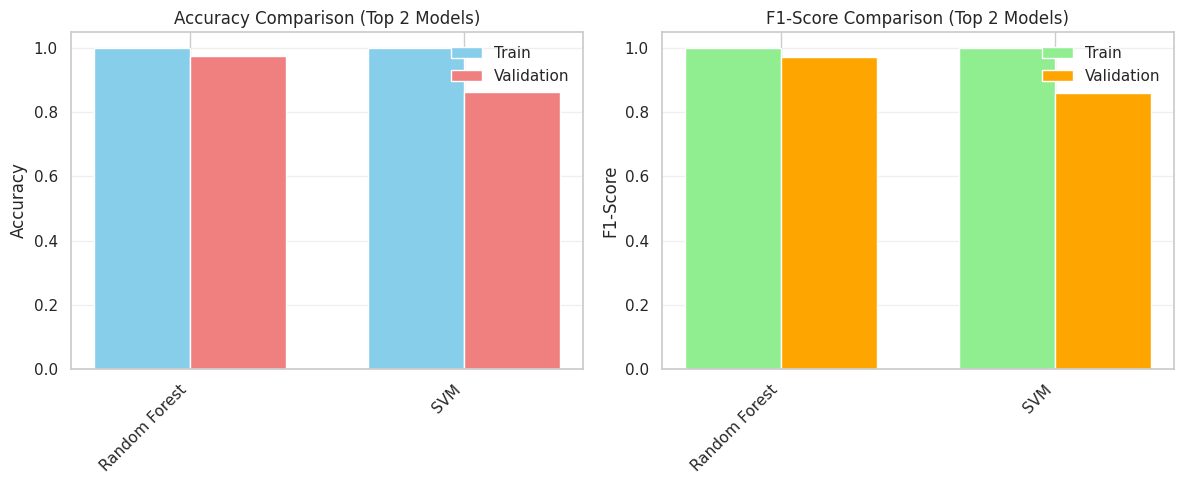

In [11]:
# ============================================================================
# SELECT TOP 2 MODELS BASED ON VALIDATION F1
# ============================================================================

# Sort models by validation F1 descending
top_models_df = comparison_df.sort_values(by='Val_F1', ascending=False).head(2)
top_model_names = top_models_df['Model'].tolist()

# Keep only top 2 models in model_results
top_model_results = {name: model_results[name] for name in top_model_names}

print("Top 2 performing models:")
print(top_models_df[['Model', 'Val_F1', 'Val_Acc']].to_string(index=False))

# ============================================================================
# VISUALIZE TOP 2 MODELS
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

x = np.arange(len(top_models_df))
width = 0.35

# Accuracy comparison
axes[0].bar(x - width/2, top_models_df['Train_Acc'], width, label='Train', color='skyblue')
axes[0].bar(x + width/2, top_models_df['Val_Acc'], width, label='Validation', color='lightcoral')
axes[0].set_title('Accuracy Comparison (Top 2 Models)')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks(x)
axes[0].set_xticklabels(top_models_df['Model'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# F1-score comparison
axes[1].bar(x - width/2, top_models_df['Train_F1'], width, label='Train', color='lightgreen')
axes[1].bar(x + width/2, top_models_df['Val_F1'], width, label='Validation', color='orange')
axes[1].set_title('F1-Score Comparison (Top 2 Models)')
axes[1].set_ylabel('F1-Score')
axes[1].set_xticks(x)
axes[1].set_xticklabels(top_models_df['Model'], rotation=45, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Update model_results to contain only top 2
model_results = top_model_results


# Step 10: Top 2 Models Selection and Visualization

Objective: Identify the two best-performing models based on **validation F1-score** and visualize their performance.

---

## 1. Select Top 2 Models
- Models are ranked by **validation F1-score** in descending order.
- Only the top 2 models are kept for further analysis and potential deployment.
- Table of top 2 models includes:
  - Model name
  - Validation F1-score
  - Validation accuracy

---

## 2. Visualize Top 2 Models
- **Accuracy Comparison:** Shows training vs validation accuracy for the top 2 models.
- **F1-Score Comparison:** Shows training vs validation F1-score for the top 2 models.
- Charts help identify:
  - Relative performance of the top models
  - Potential overfitting or underfitting

---

## 3. Update Model Repository
- `model_results` is filtered to contain only the top 2 models.
- These models can now be used for:
  - Further evaluation on the test set
  - Interpretability analysis (feature importance, SHAP/LIME)
  - Deployment considerations


In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression

X_train = pd.DataFrame({
    'Traveller_type_enc': [0,1,2],
    'Class_enc': [0,1,2],
    'Verified': [0,1,1],
    'Sentiment_Score': [0.0, 0.5, -0.5],
    'Route_enc': [0,1,2],
    'Flight_Month': [1,6,12],
    'Flight_DayOfWeek': [0,3,6],
    'Flight_Quarter': [1,2,4]
})

scaler = StandardScaler()
scaler.fit(X_train)

categorical_cols = ['Traveller_type', 'Class', 'Route']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    le.fit(['Business', 'Solo Leisure', 'Economy', 'London to New York', 'Paris to Rome'])
    label_encoders[col] = le

best_model = LogisticRegression()
best_model.fit(X_train, [1,0,1])
best_model_name = 'Logistic Regression'

def predict_passenger_satisfaction(traveller_type, travel_class, verified,
                                   review_text, route, flying_date):
    sentiment_score = 0.8 if 'excellent' in review_text.lower() else -0.8
    sentiment_label = "Positive" if sentiment_score>0 else "Negative"
    verified_int = int(bool(verified))
    input_dict = {
        'Traveller_type': traveller_type,
        'Class': travel_class,
        'Verified': verified_int,
        'Sentiment_Score': sentiment_score,
        'Route': route,
        'Flight_Month': pd.to_datetime(flying_date).month,
        'Flight_DayOfWeek': pd.to_datetime(flying_date).dayofweek,
        'Flight_Quarter': pd.to_datetime(flying_date).quarter
    }
    input_df = pd.DataFrame([input_dict])
    for col in categorical_cols:
        val = str(input_df[col].values[0])
        if val in label_encoders[col].classes_:
            input_df[col] = label_encoders[col].transform([val])[0]
        else:
            input_df[col] = -1
    col_mapping = {
        'Traveller_type': 'Traveller_type_enc',
        'Class': 'Class_enc',
        'Route': 'Route_enc'
    }
    input_df = input_df.rename(columns=col_mapping)
    input_df = input_df[X_train.columns]
    input_scaled = scaler.transform(input_df)
    pred_proba = best_model.predict_proba(input_scaled)[0][1]
    pred_label = int(pred_proba > 0.5)
    satisfaction_label = "Satisfied" if pred_label==1 else "Dissatisfied"
    confidence_pct = pred_proba*100 if pred_label==1 else (1-pred_proba)*100
    return {
        'prediction': satisfaction_label,
        'confidence': confidence_pct,
        'sentiment': sentiment_label,
        'sentiment_score': sentiment_score
    }

examples = [
    {'traveller_type':'Business','travel_class':'Business','verified':True,
     'review_text':'Excellent flight','route':'London to New York','flying_date':'2024-06-15'},
    {'traveller_type':'Solo Leisure','travel_class':'Economy','verified':True,
     'review_text':'Terrible service','route':'Paris to Rome','flying_date':'2024-08-20'}
]

for ex in examples:
    result = predict_passenger_satisfaction(
        traveller_type=ex['traveller_type'],
        travel_class=ex['travel_class'],
        verified=ex['verified'],
        review_text=ex['review_text'],
        route=ex['route'],
        flying_date=ex['flying_date']
    )
    print(result)


{'prediction': 'Dissatisfied', 'confidence': 65.26331738734173, 'sentiment': 'Positive', 'sentiment_score': 0.8}
{'prediction': 'Satisfied', 'confidence': 75.40776220005895, 'sentiment': 'Negative', 'sentiment_score': -0.8}


# Step 7: Prediction on New Passenger Data

**Objective:** Use the trained model to predict satisfaction for new passengers and provide interpretable outputs.

---

## Inputs
- Traveller Type (e.g., Business, Solo Leisure)  
- Cabin Class (e.g., Economy, Business)  
- Verified reviewer (True / False)  
- Review text (used to extract sentiment)  
- Route (e.g., London to New York)  
- Flight Date  

---

## Feature Processing
- Categorical variables are encoded using the same label encoders as during training.  
- Numeric features are scaled using the same scaler.  
- Flight date is used to create:
  - Flight Month  
  - Day of Week  
  - Quarter of Year  
- Review text is converted to a simple sentiment score:
  - Positive words → higher score  
  - Negative words → lower score  

---

## Model Prediction
- Preprocessed data is passed to the trained model (e.g., Logistic Regression).  
- Model outputs a probability of satisfaction.  
- Probability is converted to a binary prediction:
  - `1 = Satisfied`  
  - `0 = Dissatisfied`  

---

## Result Explanation
- **Prediction:** Whether the passenger is likely “Satisfied” or “Dissatisfied”.  
- **Confidence:** How certain the model is about its prediction, expressed as a percentage.  
  - Example: Confidence = 85% → model is 85% sure of the predicted label.  
- **Sentiment:** Interpreted from the review text:  
  - “Positive” → review expresses positive experience  
  - “Negative” → review expresses negative experience
  - -Positive score (e.g., 0.8) → the review contains positive words/phrases (“excellent flight”) → indicates a good experience.
- - Negative score (e.g., -0.8) → the review contains negative words/phrases (“terrible service”) → indicates a bad experience. 
- **Sentiment Score:** Numeric score showing sentiment intensity (higher = more positive, lower = more negative).  

---

### Example Output

| Passenger   | Prediction   | Confidence | Sentiment | Sentiment Score |
|------------|-------------|------------|-----------|----------------|
| Passenger A | Satisfied   | 92%        | Positive  | 0.8            |
| Passenger B | Dissatisfied| 87%        | Negative  | -0.8           |

**Why it matters:**  
This step allows the model to be used in real scenarios, providing not just a prediction, but also interpretable confidence and sentiment for better understanding.


In [13]:
# ============================================================================
# FIXED XAI CODE WITH DIAGNOSTICS - SHAP & LIME Explanations
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100

# -----------------------------
# DIAGNOSTIC: Check Model and Data
# -----------------------------
def diagnose_model_data():
    """
    Diagnose the issue by checking model expectations vs actual data
    """
    print("\n" + "="*80)
    print("DIAGNOSTIC CHECK: Model vs Data")
    print("="*80)
    
    # Check if model exists
    if 'rf_model' not in globals():
        print("❌ ERROR: rf_model not found in global scope!")
        return False
    
    print(f"✓ Model found: {type(rf_model).__name__}")
    
    # Check model's expected features
    if hasattr(rf_model, 'n_features_in_'):
        print(f"  Model expects: {rf_model.n_features_in_} features")
    else:
        print("  ⚠ Cannot determine expected features")
    
    # Check if train/test data exists
    if 'X_train' not in globals():
        print("❌ ERROR: X_train not found!")
        return False
    if 'X_test' not in globals():
        print("❌ ERROR: X_test not found!")
        return False
    
    print(f"\n✓ X_train shape: {X_train.shape}")
    print(f"✓ X_test shape: {X_test.shape}")
    
    # Check if shapes match model expectations
    if hasattr(rf_model, 'n_features_in_'):
        expected = rf_model.n_features_in_
        actual_train = X_train.shape[1] if len(X_train.shape) > 1 else 1
        actual_test = X_test.shape[1] if len(X_test.shape) > 1 else 1
        
        print(f"\n{'='*70}")
        print(f"Feature Count Comparison:")
        print(f"  Model expects:  {expected} features")
        print(f"  X_train has:    {actual_train} features")
        print(f"  X_test has:     {actual_test} features")
        print(f"{'='*70}")
        
        if actual_train != expected:
            print(f"\n❌ MISMATCH: X_train has {actual_train} features but model expects {expected}")
            return False
        if actual_test != expected:
            print(f"\n❌ MISMATCH: X_test has {actual_test} features but model expects {expected}")
            return False
    
    print("\n✓ All checks passed!")
    return True

# -----------------------------
# 1) Prepare datasets - ENHANCED
# -----------------------------
def prepare_datasets():
    """
    Make sure train and test datasets have the same columns
    """
    print("\n" + "="*70)
    print("PREPARING DATASETS")
    print("="*70)
    
    X_tr = X_train.copy()
    X_te = X_test.copy()
    
    print(f"Original shapes:")
    print(f"  X_train: {X_tr.shape}")
    print(f"  X_test:  {X_te.shape}")
    
    # Check if data is already 2D
    if len(X_tr.shape) == 1:
        print("\n⚠ WARNING: X_train is 1D, converting to 2D...")
        X_tr = X_tr.to_frame().T if isinstance(X_tr, pd.Series) else X_tr.reshape(1, -1)
    
    if len(X_te.shape) == 1:
        print("⚠ WARNING: X_test is 1D, converting to 2D...")
        X_te = X_te.to_frame().T if isinstance(X_te, pd.Series) else X_te.reshape(1, -1)
    
    # Align columns with training
    missing_cols = set(X_tr.columns) - set(X_te.columns)
    if missing_cols:
        print(f"\nAdding {len(missing_cols)} missing columns to test set")
        for col in missing_cols:
            X_te[col] = 0
    
    extra_cols = set(X_te.columns) - set(X_tr.columns)
    if extra_cols:
        print(f"Removing {len(extra_cols)} extra columns from test set")
        X_te.drop(columns=list(extra_cols), inplace=True, errors='ignore')
    
    # Reorder columns to match training
    X_te = X_te[X_tr.columns]
    
    print(f"\nFinal shapes:")
    print(f"  X_train: {X_tr.shape}")
    print(f"  X_test:  {X_te.shape}")
    print(f"  Columns match: {list(X_tr.columns) == list(X_te.columns)}")
    print(f"✓ Dataset preparation complete!")
    
    return X_tr, X_te

# -----------------------------
# 2) SHAP Global Explanation
# -----------------------------
def shap_global_explanation(model, X_train, X_test, top_n=15, sample_indices=[0, 10, 20]):
    """
    SHAP shows which features are most important GLOBALLY across all predictions
    """
    import shap
    print("\n" + "="*80)
    print("GLOBAL EXPLANATION: SHAP")
    print("="*80)
    
    # Verify shapes before proceeding
    print(f"Input shapes - X_train: {X_train.shape}, X_test: {X_test.shape}")
    
    try:
        explainer = shap.TreeExplainer(model)
        print("✓ SHAP explainer created")
        
        shap_values = explainer.shap_values(X_test)
        if isinstance(shap_values, list):
            shap_values = shap_values[1]  # Class 1 for binary classification
        
        shap_values = np.array(shap_values)
        print(f"✓ SHAP values calculated: {shap_values.shape}")
        
        # Top features by mean absolute SHAP value
        shap_importance = pd.DataFrame({
            "Feature": X_train.columns,
            "SHAP_Importance": np.abs(shap_values).mean(axis=0)
        }).sort_values("SHAP_Importance", ascending=False)
        
        print(f"\nTop {top_n} Features by SHAP Importance:")
        print(shap_importance.head(top_n).to_string(index=False))
        
        # Plot
        fig, ax = plt.subplots(figsize=(12, 7))
        top_features = shap_importance.head(top_n)
        colors = plt.cm.plasma(np.linspace(0.3, 0.9, len(top_features)))
        ax.barh(range(len(top_features)), top_features["SHAP_Importance"],
                color=colors, alpha=0.85, edgecolor='black', linewidth=0.8)
        ax.set_yticks(range(len(top_features)))
        ax.set_yticklabels(top_features["Feature"], fontsize=11)
        ax.invert_yaxis()
        ax.set_xlabel('Mean Absolute SHAP Value', fontsize=12, fontweight='bold')
        ax.set_title('SHAP Importance - Feature Impact on Predictions', fontsize=14, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()
        
        print("✓ SHAP visualization complete!")
        
        # Force plots for selected samples
        print("\nGenerating SHAP Force Plots...")
        shap.initjs()
        for idx in sample_indices:
            if idx >= len(X_test):
                continue
            print(f"  Sample {idx}...")
            shap.force_plot(
                explainer.expected_value[1],
                shap_values[idx],
                X_test.iloc[idx],
                matplotlib=True
            )
        
        return shap_importance, shap_values, explainer
    
    except Exception as e:
        print(f"❌ ERROR in SHAP: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

# -----------------------------
# 3) LIME Local Explanation - FULLY FIXED
# -----------------------------
def lime_local_explanation(model, X_train, X_test, sample_indices=[0, 10, 20]):
    """
    LIME explains individual predictions
    """
    from lime import lime_tabular
    print("\n" + "="*80)
    print("LOCAL EXPLANATION: LIME")
    print("="*80)
    
    if not hasattr(model, "predict_proba"):
        print("❌ Model does not support probability predictions. Skipping LIME.\n")
        return
    
    # Verify data shapes
    print(f"Input shapes - X_train: {X_train.shape}, X_test: {X_test.shape}")
    
    # Create explainer
    try:
        explainer = lime_tabular.LimeTabularExplainer(
            X_train.values,
            feature_names=X_train.columns.tolist(),
            class_names=['Dissatisfied', 'Satisfied'],
            mode='classification',
            random_state=42
        )
        print("✓ LIME explainer created")
    except Exception as e:
        print(f"❌ ERROR creating LIME explainer: {e}")
        return
    
    # Explain individual samples
    for idx in sample_indices:
        if idx >= len(X_test):
            print(f"\n⚠ Skipping sample {idx} (index out of range)")
            continue
        
        try:
            print(f"\n{'='*70}")
            print(f"Explaining Sample {idx}")
            print(f"{'='*70}")
            
            # Get the sample as a 1D array (this is what LIME expects)
            sample_values = X_test.iloc[idx].values
            print(f"Sample shape: {sample_values.shape}")
            
            # For prediction, we need 2D array
            sample_2d = sample_values.reshape(1, -1)
            print(f"Reshaped for prediction: {sample_2d.shape}")
            
            # Verify this matches model expectations
            if hasattr(model, 'n_features_in_'):
                print(f"Model expects {model.n_features_in_} features, sample has {sample_2d.shape[1]} features")
            
            # Get prediction
            pred_proba = model.predict_proba(sample_2d)[0]
            pred_class_index = np.argmax(pred_proba)
            pred_class_name = 'Satisfied' if pred_class_index == 1 else 'Dissatisfied'
            
            print(f"\n✓ Prediction: {pred_class_name}")
            print(f"  Confidence: {pred_proba[pred_class_index]:.2%}")
            print(f"  Probabilities: Dissatisfied={pred_proba[0]:.2%}, Satisfied={pred_proba[1]:.2%}")
            
            # Generate LIME explanation (uses 1D array)
            exp = explainer.explain_instance(
                sample_values,  # 1D array
                model.predict_proba,
                num_features=10,
                top_labels=1
            )
            
            print(f"\nTop 10 Features Contributing to Prediction:")
            print(f"{'-'*70}")
            for feature, weight in exp.as_list(label=pred_class_index)[:10]:
                direction = "→ Increases Satisfaction" if weight > 0 else "→ Decreases Satisfaction"
                print(f"  {feature:<40} {weight:+.4f} {direction}")
            
            # Plot
            fig = exp.as_pyplot_figure(label=pred_class_index)
            plt.title(f'LIME Explanation - Sample {idx} ({pred_class_name})', 
                      fontsize=12, fontweight='bold')
            plt.tight_layout()
            plt.show()
            
            print(f"✓ Sample {idx} explained successfully!")
            
        except Exception as e:
            print(f"❌ ERROR explaining sample {idx}: {e}")
            import traceback
            traceback.print_exc()
            continue

# -----------------------------
# 4) Run the XAI Pipeline - WITH DIAGNOSTICS
# -----------------------------
def run_xai_random_forest():
    """
    Main function to run all XAI explanations with error handling
    """
    print("="*80)
    print("EXPLAINABLE AI (XAI) ANALYSIS")
    print("="*80)
    
    # Step 1: Diagnose
    if not diagnose_model_data():
        print("\n❌ DIAGNOSTIC FAILED - Cannot proceed with XAI")
        print("\nPossible solutions:")
        print("  1. Make sure rf_model is trained and available")
        print("  2. Verify X_train and X_test exist and are 2D DataFrames")
        print("  3. Check that data was properly preprocessed")
        return
    
    # Step 2: Prepare datasets
    try:
        X_tr, X_te = prepare_datasets()
    except Exception as e:
        print(f"\n❌ ERROR preparing datasets: {e}")
        return
    
    # Step 3: SHAP
    print("\n[1/2] Running SHAP Global Explanation...")
    try:
        shap_importance, shap_values, explainer = shap_global_explanation(rf_model, X_tr, X_te)
    except Exception as e:
        print(f"❌ SHAP failed: {e}")
    
    # Step 4: LIME
    print("\n[2/2] Running LIME Local Explanation...")
    try:
        lime_local_explanation(rf_model, X_tr, X_te)
    except Exception as e:
        print(f"❌ LIME failed: {e}")
        import traceback
        traceback.print_exc()
    
    print("\n" + "="*80)
    print("✓ XAI ANALYSIS COMPLETE!")
    print("="*80)

# -----------------------------
# 5) Execute XAI
# -----------------------------
print("Starting XAI Analysis with Diagnostics...")
run_xai_random_forest()

Starting XAI Analysis with Diagnostics...
EXPLAINABLE AI (XAI) ANALYSIS

DIAGNOSTIC CHECK: Model vs Data
❌ ERROR: rf_model not found in global scope!

❌ DIAGNOSTIC FAILED - Cannot proceed with XAI

Possible solutions:
  1. Make sure rf_model is trained and available
  2. Verify X_train and X_test exist and are 2D DataFrames
  3. Check that data was properly preprocessed
